 * @ Author: Yohei Ohto
 * @ Create Time: 2025-03-31 18:54:24
 * @ Modified time: 2025-08-13 14:24:13
 * @ Description: compare random population, ga result and validation test dataset

- Data files used in the code:
    - `../../data/processed/{test_name}/cas_sev_use.tsv`: Contains CAS numbers and toxicity information for compounds.
    - `../../data/processed/{test_name}/validation_pubchem.tsv`: Contains validation data for compounds, including CAS numbers and toxicity.
    - `../../data/processed/{test_name}/for_GA_lookup.pickle`: Lookup table for compound pairs, providing structure and physical property scores.
    - `../../data/processed/{test_name}/validation_lookup.pickle`: Lookup table for validation compound pairs, providing structure and physical property scores.
    - `../../data/result/{test_name}/GA_{trys}/score.tsv`: Contains scores from genetic algorithm (GA) results for compound lists.

- Image files generated by the code:
    - `../../data/result/{test_name}/GA_{trys}/fig1/A_structure_comp_random_only_val.png`: Histogram and plot for structure scores (random population vs validation only).
    - `../../data/result/{test_name}/GA_{trys}/fig1/B_toxicity_comp_random_only_val.png`: Histogram/bar plot for toxicity scores (random population vs validation only).
    - `../../data/result/{test_name}/GA_{trys}/fig1/C_physical_property_comp_random_only_val.png`: Histogram and plot for physical property scores (random population vs validation only).
    - `../../data/result/{test_name}/GA_{trys}/fig4/A_structure_comp_random.png`: Histogram and plot comparing structure scores (random population, GA result, validation) for all tests.
    - `../../data/result/{test_name}/GA_{trys}/fig4/B_toxicity_comp_random.png`: Histogram/bar plot comparing toxicity scores (random population, GA result, validation) for all tests.
    - `../../data/result/{test_name}/GA_{trys}/fig4/C_physical_property_comp_random.png`: Histogram and plot comparing physical property scores (random population, GA result, validation) for all tests.

In [1]:
import os
import sys

current_dir = os.getcwd()
parent_parent_dir = os.path.dirname(os.path.dirname(current_dir))
src_dir = os.path.join(parent_parent_dir, 'src')
sys.path.append(src_dir)

import ast
import itertools
import math
import random
import time
from math import comb
from statistics import variance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from deap import algorithms, base, creator, tools
from ga import not_dup, rand_nodup
from rdkit import Chem
from rdkit.Chem import Draw
from scipy.stats import norm
from tqdm import tqdm
from util import pickle_load, robust_z

In [2]:
# validation test name
test_num = "0905"
ligand = "anta"
date = 241219
num = 1

In [3]:
trys = str(date) + "_" + str(num)

if ligand in ["ago", "anta"]:
    test_name = test_num + "_" + ligand
else:
    test_name = test_num
    
lookup = pickle_load(f"../../data/processed/{test_name}/for_GA_lookup.pickle")
cas_tox = pd.read_csv(f"../../data/processed/{test_name}/cas_sev_use.tsv", sep="\t", header=None)
val = pd.read_csv(f"../../data/processed/{test_name}/validation_pubchem.tsv", sep="\t", header=None) 
val_lookup = pickle_load(f"../../data/processed/{test_name}/validation_lookup.pickle")

scores = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/score.tsv", sep="\t", header=None)

In [4]:
all_cass = []
all_toxs = []
for i in range(len(cas_tox)):
    all_cass.append(cas_tox.iloc[i,0])
    all_toxs.append(cas_tox.iloc[i,1])

if len(set(all_toxs)) == 2:
    tox_scoring = "descrete"
else:
    tox_scoring = "continuous"

if tox_scoring == "continuous":
    standardized_toxs = robust_z(all_toxs)
elif tox_scoring == "descrete":
    standardized_toxs = all_toxs

def multi_objective_optimization(individual):
    structure_score = 0
    phisical_score = 0
    penalty = [100000, -100000, -100000]

    if len(individual) != IND_INIT_SIZE:
        return penalty[0], penalty[1], penalty[2]
    
    toxs = []
    for i in range(len(list(individual))):
        num = list(individual)[i]
        toxs.append(standardized_toxs[num])

    if tox_scoring == "descrete":
        count_t = 0
        for i in range(len(toxs)):
            if toxs[i] == 1:
                count_t += 1
        N = len(toxs)
        p = 0.5
        likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
        toxicity_score = math.log(likelihood)

    elif tox_scoring == "continuous":
        toxicity_score = np.std(toxs)

    t = list(itertools.combinations(individual,2))
    for i in range(len(t)):
        if t[i][0] == t[i][1]:
            print("!", flush=True)
            return penalty[0], penalty[1], penalty[2]

    for i in range(len(t)):
        try:
            dict_t = lookup[f"{all_cass[t[i][0]]}, {all_cass[t[i][1]]}"]
        except:
            dict_t = lookup[f"{all_cass[t[i][1]]}, {all_cass[t[i][0]]}"]
        structure = dict_t[0]
        phisical = dict_t[1]
        structure_score += structure
        phisical_score += phisical

    return structure_score, phisical_score, toxicity_score

In [5]:
tox_r_fp = []
bussei_r_fp = []
tani_r_fp = [] 

count = 0
IND_INIT_SIZE = len(val)

now = time.ctime()
cnvtime = time.strptime(now)
print(time.strftime("%Y/%m/%d %H:%M", cnvtime), flush=True)

while count < 10000:
    if count == 10:
        now = time.ctime()
        strtime = time.strptime(now)
        print(time.strftime("%Y/%m/%d %H:%M", strtime), flush=True)
    if count % 1000 == 0 and count != 0:
        now = time.ctime()
        strtime = time.strptime(now)
        print(f"--------{count}--------")
        print(time.strftime("%Y/%m/%d %H:%M", strtime), flush=True)
    a = [random.randint(0, len(cas_tox)-1) for i in range(IND_INIT_SIZE)] 
    a = set(a)
    while len(a) != IND_INIT_SIZE:
        a.add(random.randint(0, len(cas_tox)-1))
    score_moo = multi_objective_optimization(a)
    tox_r_fp.append(score_moo[2])
    bussei_r_fp.append(score_moo[1])
    tani_r_fp.append(score_moo[0])
    count += 1

2025/08/13 15:41
2025/08/13 15:41
--------1000--------
2025/08/13 15:41
--------2000--------
2025/08/13 15:41
--------3000--------
2025/08/13 15:41
--------4000--------
2025/08/13 15:41
--------5000--------
2025/08/13 15:41
--------6000--------
2025/08/13 15:41
--------7000--------
2025/08/13 15:41
--------8000--------
2025/08/13 15:41
--------9000--------
2025/08/13 15:41


In [6]:
val_cas = []
val_toxs = []
for i in range(len(val)):
    val_cas.append(val.iloc[i,0])
    val_toxs.append(val.iloc[i,1])

if len(set(val_toxs)) == 2:
    tox_scoring = "descrete"
else:
    tox_scoring = "continuous"

if tox_scoring == "continuous":
    standardized_toxs_val = robust_z(val_toxs)
elif tox_scoring == "descrete":
    standardized_toxs_val = val_toxs

def multi_objective_optimization_val(individual):
    structure_score = 0
    phisical_score = 0
    penalty = [100000, -100000, -100000]
    
    toxs = []
    for i in range(len(list(individual))):
        num = list(individual)[i]
        toxs.append(standardized_toxs_val[num])

    if tox_scoring == "descrete":
        count_t = 0
        for i in range(len(toxs)):
            if toxs[i] == 1:
                count_t += 1
        N = len(toxs)
        p = 0.5
        likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
        toxicity_score = math.log(likelihood)

    elif tox_scoring == "continuous":
        toxicity_score = np.std(toxs)

    t = list(itertools.combinations(individual,2))
    for i in range(len(t)):
        if t[i][0] == t[i][1]:
            print("!", flush=True)
            return penalty[0], penalty[1], penalty[2]

    for i in range(len(t)):
        try:
            dict_t = val_lookup[f"{val_cas[t[i][0]]}, {val_cas[t[i][1]]}"]
        except:
            dict_t = val_lookup[f"{val_cas[t[i][1]]}, {val_cas[t[i][0]]}"]
        structure = dict_t[0]
        phisical = dict_t[1]
        structure_score += structure
        phisical_score += phisical

    return structure_score, phisical_score, toxicity_score

val_num = [i for i in range(len(val))]
val_score = multi_objective_optimization_val(val_num)

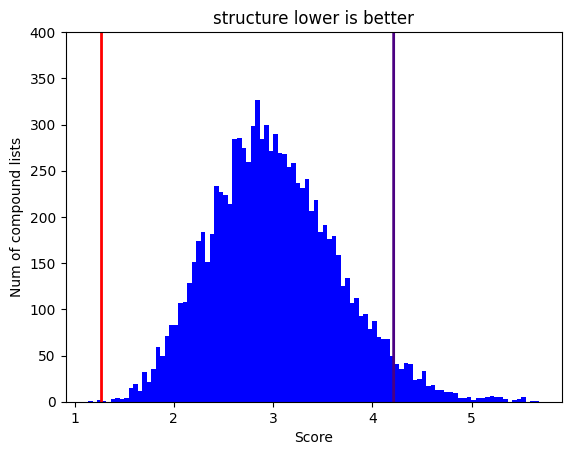

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

y = np.arange(0, 600, 0.5)

x = []
for i in range(len(y)):
    x.append(scores.iloc[-1,0])

x_1 = []
for i in range(len(y)):
    x_1.append(val_score[0])

ax.hist(tani_r_fp, bins=100, color="blue")
ax.set_title('structure lower is better')
ax.set_xlabel('Score')
ax.set_ylabel('Num of compound lists')

ax.set_ylim(0,400)
ax.plot(x, y, '-', linewidth=2, color="red")
ax.plot(x_1, y, '-', linewidth=2, color="indigo")
fig.show()

os.makedirs(f"../../data/result/{test_name}/GA_{trys}/fig1", exist_ok=True)
plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig1/A_structure_comp_random.png")

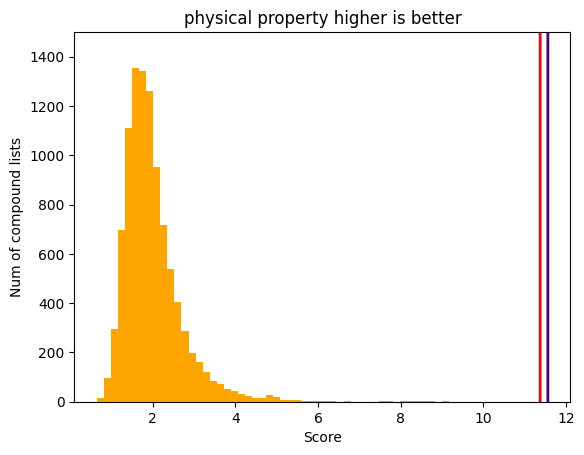

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

y = np.arange(0, 1500, 0.5)

x = []
for i in range(len(y)):
    x.append(scores.iloc[-1,2])

x_1 = []
for i in range(len(y)):
    x_1.append(val_score[1])

ax.set_title('physical property higher is better')
ax.set_xlabel('Score')
ax.set_ylabel('Num of compound lists')

ax.set_ylim(0, 1500)
ax.plot(x, y, '-', linewidth=2, color="red")
ax.plot(x_1, y, '-', linewidth=2, color="indigo")
fig.show()
plt.hist(bussei_r_fp, bins=50, color="orange")
plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig1/C_physical_property_comp_random.png")

Counter({-1.807507826196194: 2883, -2.6548056865833978: 2712, -1.4020427180880297: 2336, -4.041100047703289: 1634, -6.238324625039508: 435})


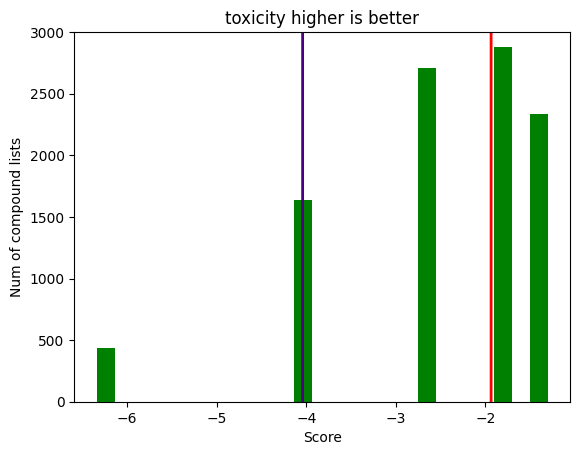

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

y = np.arange(0, 3000, 0.5)

x = []
for i in range(len(y)):
    x.append(scores.iloc[-1,4])

x_1 = []
for i in range(len(y)):
    x_1.append(val_score[2])

import collections
c = collections.Counter(tox_r_fp)
print(c)
ax.set_title('toxicity higher is better')
ax.set_xlabel('Score')
ax.set_ylabel('Num of compound lists')

ax.set_ylim(0, 3000)
ax.plot(x, y, '-', linewidth=2, color="red")
ax.plot(x_1, y, '-', linewidth=2, color="indigo")
fig.show()
plt.bar(list(c.keys()), list(c.values()), width=0.2, color="green")
plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig1/B_toxicity_comp_random.png")

# Run all tests at the same time (only validation dataset)

In [ ]:
import collections
for test_num in tqdm(["0701", "0702", "0907", "1001", "1002", "0901", "0902", "0904", "0905"]):
    for lig in ["ago", "anta"]:

        if test_num in ["0701", "0702", "0907", "1001", "1002"]:
            if lig == "ago":
                lig = "!"
            else:
                continue

        date = 241219
        num = 1
        
        trys = str(date) + "_" + str(num)
        if lig in ["ago", "anta"]:
            test_name = test_num + "_" + lig
        else:
            test_name = test_num
        
        lookup = pickle_load(f"../../data/processed/{test_name}/for_GA_lookup.pickle")
        cas_tox = pd.read_csv(f"../../data/processed/{test_name}/cas_sev_use.tsv", sep="\t", header=None)
        val = pd.read_csv(f"../../data/processed/{test_name}/validation_pubchem.tsv", sep="\t", header=None) 
        val_lookup = pickle_load(f"../../data/processed/{test_name}/validation_lookup.pickle")
        scores = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/score.tsv", sep="\t", header=None)
        
        all_cass = []
        all_toxs = []
        for i in range(len(cas_tox)):
            all_cass.append(cas_tox.iloc[i,0])
            all_toxs.append(cas_tox.iloc[i,1])

        if len(set(all_toxs)) == 2:
            tox_scoring = "descrete"
        else:
            tox_scoring = "continuous"

        if tox_scoring == "continuous":
            standardized_toxs = robust_z(all_toxs)
        elif tox_scoring == "descrete":
            standardized_toxs = all_toxs

        def multi_objective_optimization(individual):
            structure_score = 0
            phisical_score = 0
            penalty = [100000, -100000, -100000]

            if len(individual) != IND_INIT_SIZE:
                return penalty[0], penalty[1], penalty[2]
            
            toxs = []
            for i in range(len(list(individual))):
                num = list(individual)[i]
                toxs.append(standardized_toxs[num])

            if tox_scoring == "descrete":
                count_t = 0
                for i in range(len(toxs)):
                    if toxs[i] == 1:
                        count_t += 1
                N = len(toxs)
                p = 0.5
                likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
                toxicity_score = math.log(likelihood)

            elif tox_scoring == "continuous":
                toxicity_score = np.std(toxs)

            t = list(itertools.combinations(individual,2))
            for i in range(len(t)):
                if t[i][0] == t[i][1]:
                    print("!", flush=True)
                    return penalty[0], penalty[1], penalty[2]

            for i in range(len(t)):
                try:
                    dict_t = lookup[f"{all_cass[t[i][0]]}, {all_cass[t[i][1]]}"]
                except:
                    dict_t = lookup[f"{all_cass[t[i][1]]}, {all_cass[t[i][0]]}"]
                structure = dict_t[0]
                phisical = dict_t[1]
                structure_score += structure
                phisical_score += phisical

            return structure_score, phisical_score, toxicity_score

        val_cas = []
        val_toxs = []
        for i in range(len(val)):
            val_cas.append(val.iloc[i,0])
            val_toxs.append(val.iloc[i,1])

        if len(set(val_toxs)) == 2:
            tox_scoring = "descrete"
        else:
            tox_scoring = "continuous"

        if tox_scoring == "continuous":
            standardized_toxs_val = robust_z(val_toxs)
        elif tox_scoring == "descrete":
            standardized_toxs_val = val_toxs

        def multi_objective_optimization_val(individual):
            structure_score = 0
            phisical_score = 0
            penalty = [100000, -100000, -100000]
            
            toxs = []
            for i in range(len(list(individual))):
                num = list(individual)[i]
                toxs.append(standardized_toxs_val[num])

            if tox_scoring == "descrete":
                count_t = 0
                for i in range(len(toxs)):
                    if toxs[i] == 1:
                        count_t += 1
                N = len(toxs)
                p = 0.5
                likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
                toxicity_score = math.log(likelihood)

            elif tox_scoring == "continuous":
                toxicity_score = np.std(toxs)

            t = list(itertools.combinations(individual,2))
            for i in range(len(t)):
                if t[i][0] == t[i][1]:
                    print("!", flush=True)
                    return penalty[0], penalty[1], penalty[2]

            for i in range(len(t)):
                try:
                    dict_t = val_lookup[f"{val_cas[t[i][0]]}, {val_cas[t[i][1]]}"]
                except:
                    dict_t = val_lookup[f"{val_cas[t[i][1]]}, {val_cas[t[i][0]]}"]
                structure = dict_t[0]
                phisical = dict_t[1]
                structure_score += structure
                phisical_score += phisical

            return structure_score, phisical_score, toxicity_score

        val_num = [i for i in range(len(val))]
        val_score = multi_objective_optimization_val(val_num)

        tox_r_fp = []
        bussei_r_fp = []
        tani_r_fp = [] 

        count = 0
        IND_INIT_SIZE = len(val)

        while count < 10000:
            a = [random.randint(0, len(cas_tox)-1) for i in range(IND_INIT_SIZE)] 
            a = set(a)
            while len(a) != IND_INIT_SIZE:
                a.add(random.randint(0, len(cas_tox)-1))
            score_moo = multi_objective_optimization(a)
            tox_r_fp.append(score_moo[2])
            bussei_r_fp.append(score_moo[1])
            tani_r_fp.append(score_moo[0])
            count += 1
        
        os.makedirs(f"../../data/result/{test_name}/GA_{trys}/fig1", exist_ok=True)

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        y = np.arange(0, 600, 0.5)
        x_1 = []
        for i in range(len(y)):
            x_1.append(val_score[0])

        ax.hist(tani_r_fp, bins=100, color="blue")
        ax.set_title('structure lower is better')
        ax.set_xlabel('Score')
        ax.set_ylabel('Num of compound lists')
        ax.set_ylim(0,400)
        ax.plot(x_1, y, '-', linewidth=2, color="indigo")
        fig.show()
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig1/A_structure_comp_random_only_val.png")

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        y = np.arange(0, 1500, 0.5)
        x_1 = []
        for i in range(len(y)):
            x_1.append(val_score[1])

        ax.set_title('physical property higher is better')
        ax.set_xlabel('Score')
        ax.set_ylabel('Num of compound lists')
        ax.set_ylim(0, 1500)
        ax.plot(x_1, y, '-', linewidth=2, color="indigo")
        fig.show()
        plt.hist(bussei_r_fp, bins=50, color="orange")
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig1/C_physical_property_comp_random_only_val.png")

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        y = np.arange(0, 3000, 0.5)
        x = []
        for i in range(len(y)):
            x.append(scores.iloc[-1,4])
        x_1 = []
        for i in range(len(y)):
            x_1.append(val_score[2])

        if tox_scoring == "descrete":
            c = collections.Counter(tox_r_fp)
            ax.set_title('toxicity higher is better')
            ax.set_xlabel('Score')
            ax.set_ylabel('Num of compound lists')
            ax.set_ylim(0, 3000)
            ax.plot(x_1, y, '-', linewidth=2, color="indigo")
            plt.bar(list(c.keys()), list(c.values()), width=0.2, color="green")
            fig.show()
        elif tox_scoring == "continuous":
            plt.hist(tox_r_fp, bins=50, color="green")
            ax.set_title('toxicity higher is better')
            ax.set_xlabel('Score')
            ax.set_ylabel('Num of compound lists')
            ax.set_ylim(0, 3000)
            ax.plot(x_1, y, '-', linewidth=2, color="indigo")
            fig.show()
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig1/B_toxicity_comp_random_only_val.png")

# Run all tests at the same time

100%|██████████| 9/9 [09:40<00:00, 64.45s/it] 


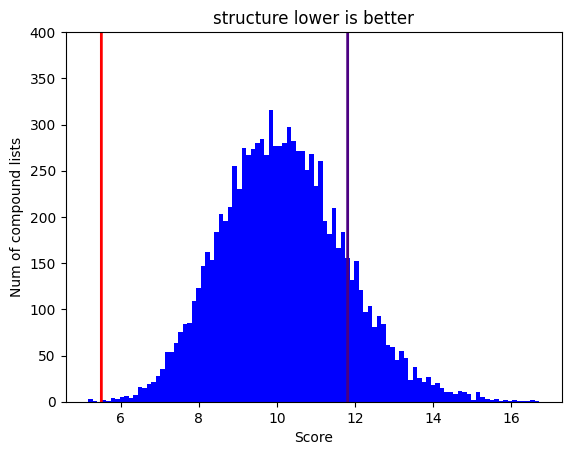

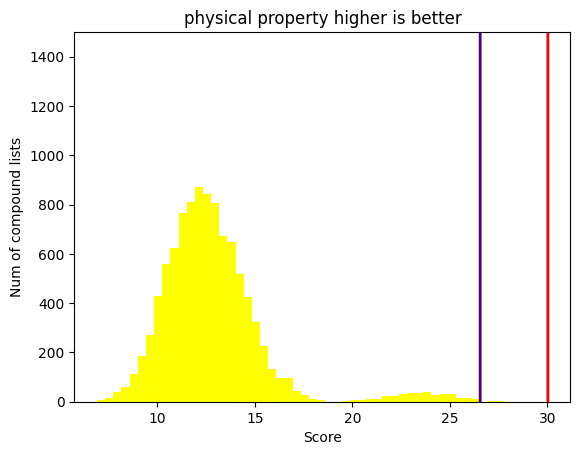

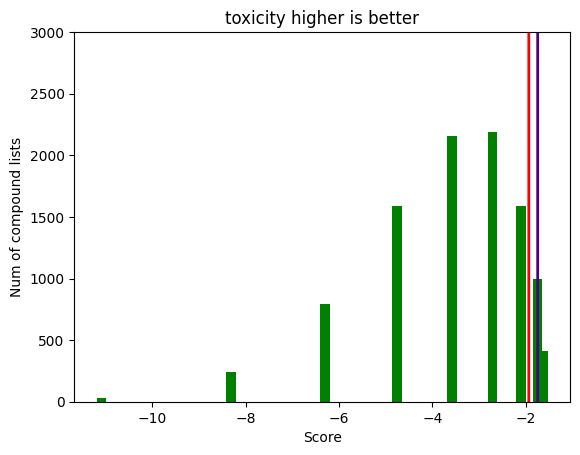

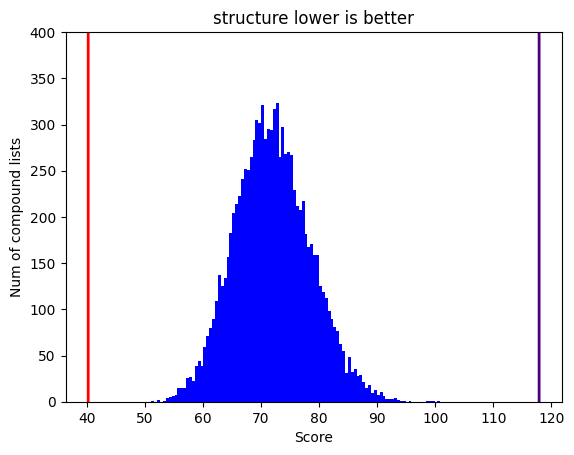

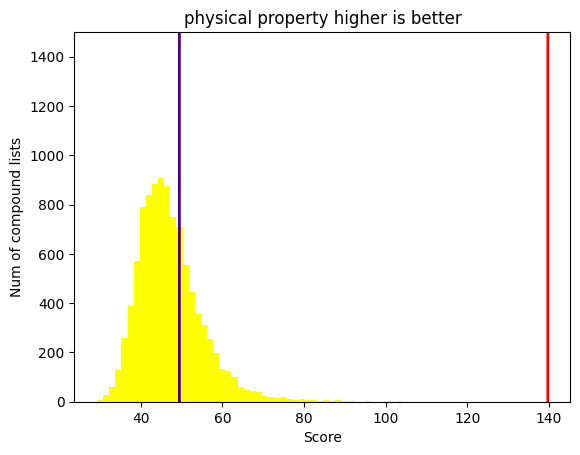

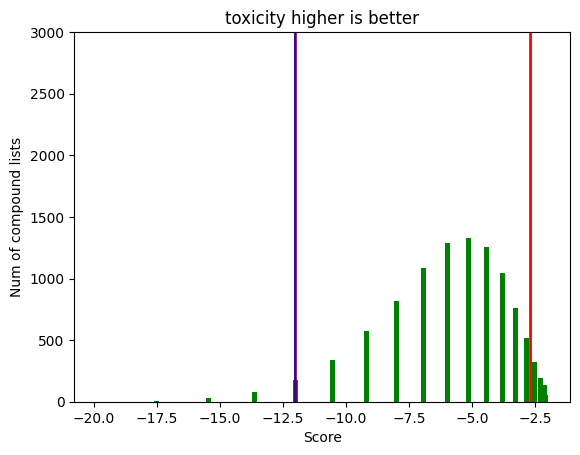

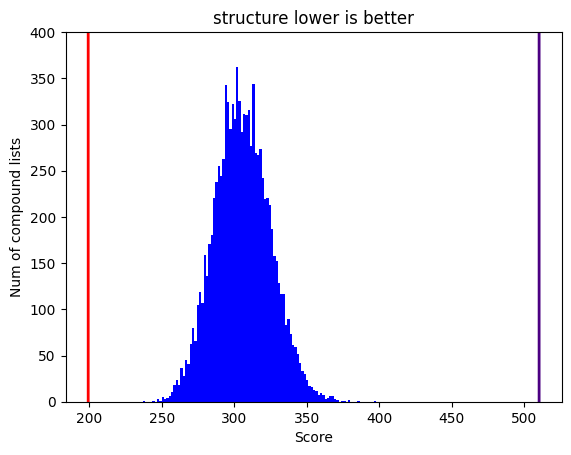

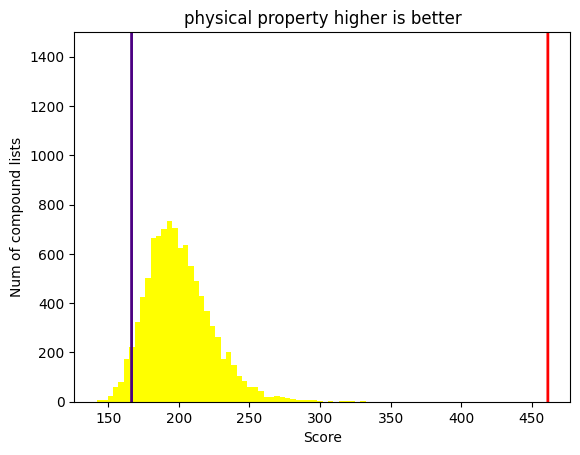

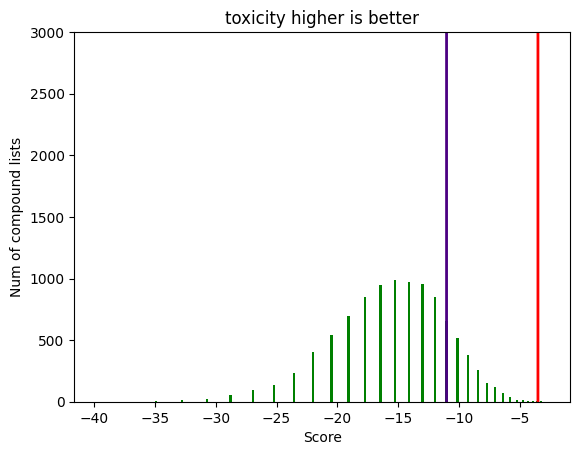

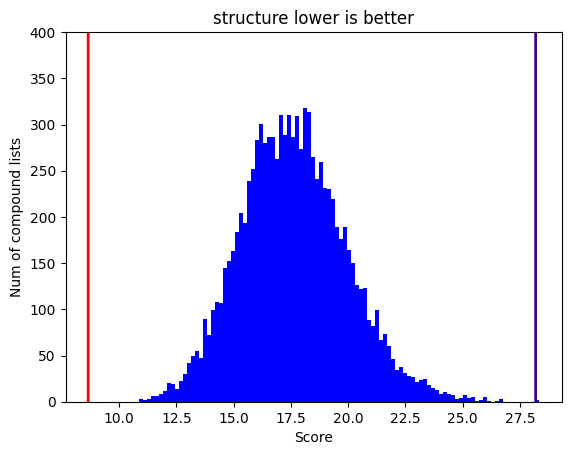

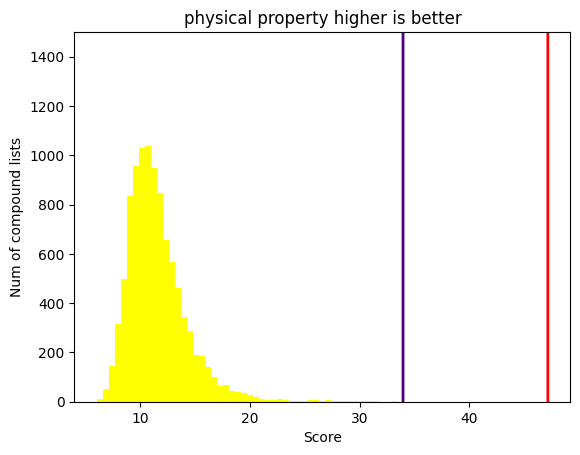

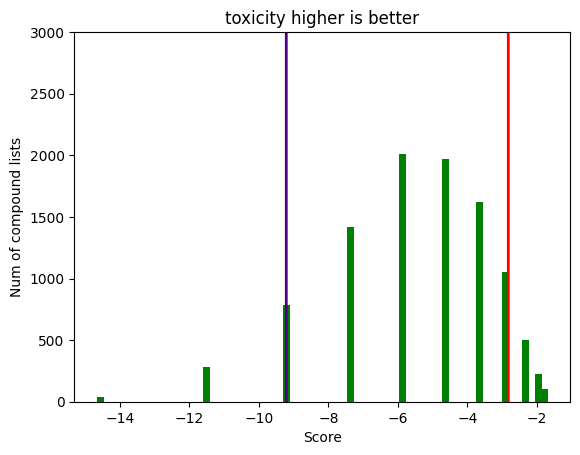

In [ ]:
import collections
for test_num in tqdm(["0701", "0702", "0907", "1001", "1002", "0901", "0902", "0904", "0905"]):
    for lig in ["ago", "anta"]:

        if test_num in ["0701", "0702", "0907", "1001", "1002"]:
            if lig == "ago":
                lig = "!"
            else:
                continue

        date = 241219
        num = 1
        
        trys = str(date) + "_" + str(num)
        if lig in ["ago", "anta"]:
            test_name = test_num + "_" + lig
        else:
            test_name = test_num
        
        lookup = pickle_load(f"../../data/processed/{test_name}/for_GA_lookup.pickle")
        cas_tox = pd.read_csv(f"../../data/processed/{test_name}/cas_sev_use.tsv", sep="\t", header=None)
        val = pd.read_csv(f"../../data/processed/{test_name}/validation_pubchem.tsv", sep="\t", header=None) 
        val_lookup = pickle_load(f"../../data/processed/{test_name}/validation_lookup.pickle")
        scores = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/score.tsv", sep="\t", header=None)
        
        all_cass = []
        all_toxs = []
        for i in range(len(cas_tox)):
            all_cass.append(cas_tox.iloc[i,0])
            all_toxs.append(cas_tox.iloc[i,1])

        if len(set(all_toxs)) == 2:
            tox_scoring = "descrete"
        else:
            tox_scoring = "continuous"

        if tox_scoring == "continuous":
            standardized_toxs = robust_z(all_toxs)
        elif tox_scoring == "descrete":
            standardized_toxs = all_toxs

        def multi_objective_optimization(individual):
            structure_score = 0
            phisical_score = 0
            penalty = [100000, -100000, -100000]

            if len(individual) != IND_INIT_SIZE:
                return penalty[0], penalty[1], penalty[2]
            
            toxs = []
            for i in range(len(list(individual))):
                num = list(individual)[i]
                toxs.append(standardized_toxs[num])

            if tox_scoring == "descrete":
                count_t = 0
                for i in range(len(toxs)):
                    if toxs[i] == 1:
                        count_t += 1
                N = len(toxs)
                p = 0.5
                likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
                toxicity_score = math.log(likelihood)

            elif tox_scoring == "continuous":
                toxicity_score = np.std(toxs)

            t = list(itertools.combinations(individual,2))
            for i in range(len(t)):
                if t[i][0] == t[i][1]:
                    print("!", flush=True)
                    return penalty[0], penalty[1], penalty[2]

            for i in range(len(t)):
                try:
                    dict_t = lookup[f"{all_cass[t[i][0]]}, {all_cass[t[i][1]]}"]
                except:
                    dict_t = lookup[f"{all_cass[t[i][1]]}, {all_cass[t[i][0]]}"]
                structure = dict_t[0]
                phisical = dict_t[1]
                structure_score += structure
                phisical_score += phisical

            return structure_score, phisical_score, toxicity_score

        val_cas = []
        val_toxs = []
        for i in range(len(val)):
            val_cas.append(val.iloc[i,0])
            val_toxs.append(val.iloc[i,1])

        if len(set(val_toxs)) == 2:
            tox_scoring = "descrete"
        else:
            tox_scoring = "continuous"

        if tox_scoring == "continuous":
            standardized_toxs_val = robust_z(val_toxs)
        elif tox_scoring == "descrete":
            standardized_toxs_val = val_toxs

        def multi_objective_optimization_val(individual):
            structure_score = 0
            phisical_score = 0
            penalty = [100000, -100000, -100000]
            
            toxs = []
            for i in range(len(list(individual))):
                num = list(individual)[i]
                toxs.append(standardized_toxs_val[num])

            if tox_scoring == "descrete":
                count_t = 0
                for i in range(len(toxs)):
                    if toxs[i] == 1:
                        count_t += 1
                N = len(toxs)
                p = 0.5
                likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
                toxicity_score = math.log(likelihood)

            elif tox_scoring == "continuous":
                toxicity_score = np.std(toxs)

            t = list(itertools.combinations(individual,2))
            for i in range(len(t)):
                if t[i][0] == t[i][1]:
                    print("!", flush=True)
                    return penalty[0], penalty[1], penalty[2]

            for i in range(len(t)):
                try:
                    dict_t = val_lookup[f"{val_cas[t[i][0]]}, {val_cas[t[i][1]]}"]
                except:
                    dict_t = val_lookup[f"{val_cas[t[i][1]]}, {val_cas[t[i][0]]}"]
                structure = dict_t[0]
                phisical = dict_t[1]
                structure_score += structure
                phisical_score += phisical

            return structure_score, phisical_score, toxicity_score

        val_num = [i for i in range(len(val))]
        val_score = multi_objective_optimization_val(val_num)

        tox_r_fp = []
        bussei_r_fp = []
        tani_r_fp = [] 

        count = 0
        IND_INIT_SIZE = len(val)

        while count < 10000:
            a = [random.randint(0, len(cas_tox)-1) for i in range(IND_INIT_SIZE)] 
            a = set(a)
            while len(a) != IND_INIT_SIZE:
                a.add(random.randint(0, len(cas_tox)-1))
            score_moo = multi_objective_optimization(a)
            tox_r_fp.append(score_moo[2])
            bussei_r_fp.append(score_moo[1])
            tani_r_fp.append(score_moo[0])
            count += 1
        
        os.makedirs(f"../../data/result/{test_name}/GA_{trys}/fig4", exist_ok=True)

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        y = np.arange(0, 600, 0.5)
        x = []
        for i in range(len(y)):
            x.append(scores.iloc[-1,0])
        x_1 = []
        for i in range(len(y)):
            x_1.append(val_score[0])

        ax.hist(tani_r_fp, bins=100, color="blue")
        ax.set_title('structure lower is better')
        ax.set_xlabel('Score')
        ax.set_ylabel('Num of compound lists')
        ax.set_ylim(0,400)
        ax.plot(x, y, '-', linewidth=2, color="red")
        ax.plot(x_1, y, '-', linewidth=2, color="indigo")
        fig.show()
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig4/A_structure_comp_random.png")

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        y = np.arange(0, 1500, 0.5)
        x = []
        for i in range(len(y)):
            x.append(scores.iloc[-1,2])
        x_1 = []
        for i in range(len(y)):
            x_1.append(val_score[1])

        ax.set_title('physical property higher is better')
        ax.set_xlabel('Score')
        ax.set_ylabel('Num of compound lists')
        ax.set_ylim(0, 1500)
        ax.plot(x, y, '-', linewidth=2, color="red")
        ax.plot(x_1, y, '-', linewidth=2, color="indigo")
        fig.show()
        plt.hist(bussei_r_fp, bins=50, color="orange")
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig4/C_physical_property_comp_random.png")

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        y = np.arange(0, 3000, 0.5)
        x = []
        for i in range(len(y)):
            x.append(scores.iloc[-1,4])
        x_1 = []
        for i in range(len(y)):
            x_1.append(val_score[2])

        if tox_scoring == "descrete":
            c = collections.Counter(tox_r_fp)
            ax.set_title('toxicity higher is better')
            ax.set_xlabel('Score')
            ax.set_ylabel('Num of compound lists')
            ax.set_ylim(0, 3000)
            ax.plot(x, y, '-', linewidth=2, color="red")
            ax.plot(x_1, y, '-', linewidth=2, color="indigo")
            plt.bar(list(c.keys()), list(c.values()), width=0.2, color="green")
            fig.show()
        elif tox_scoring == "continuous":
            plt.hist(tox_r_fp, bins=50, color="green")
            ax.set_title('toxicity higher is better')
            ax.set_xlabel('Score')
            ax.set_ylabel('Num of compound lists')
            ax.set_ylim(0, 3000)
            ax.plot(x, y, '-', linewidth=2, color="red")
            ax.plot(x_1, y, '-', linewidth=2, color="indigo")
            fig.show()
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig4/B_toxicity_comp_random.png")

# Run All tests

 33%|███▎      | 3/9 [11:46<22:34, 225.83s/it]/tmp/ipykernel_1393851/3008709946.py:199: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()
100%|██████████| 9/9 [40:15<00:00, 268.39s/it]


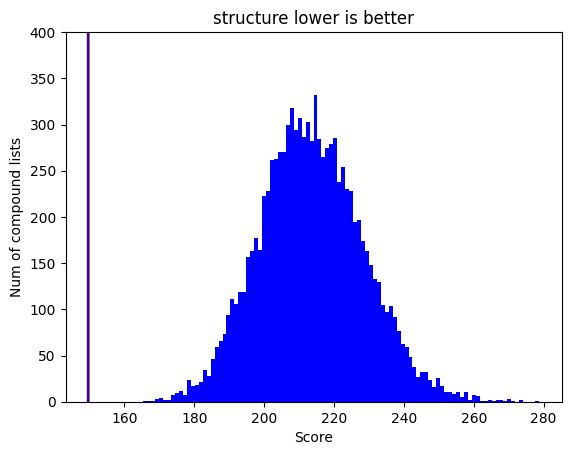

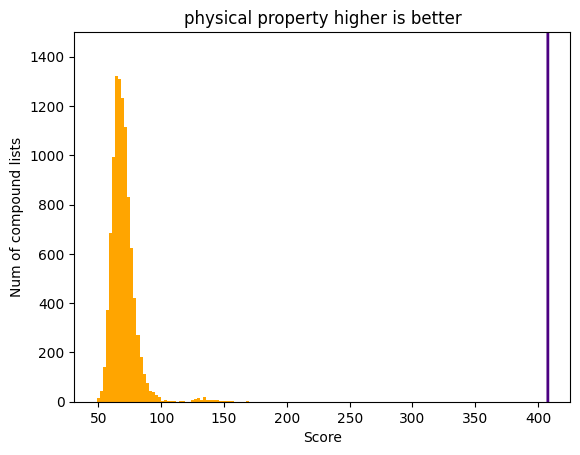

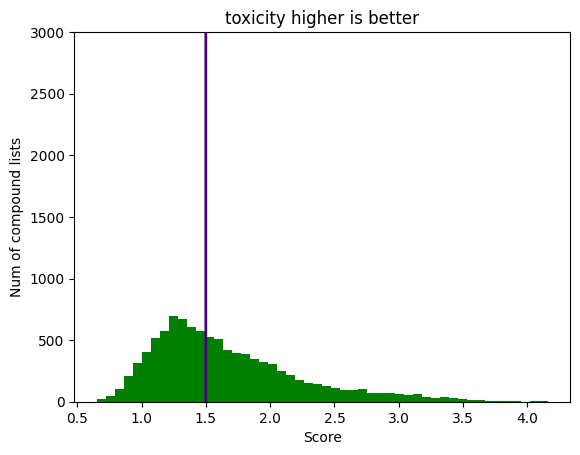

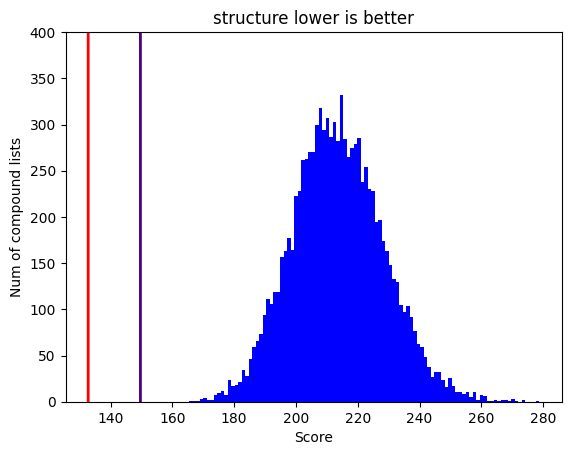

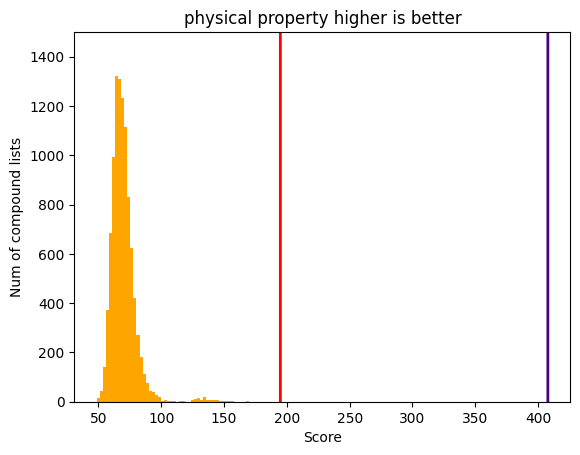

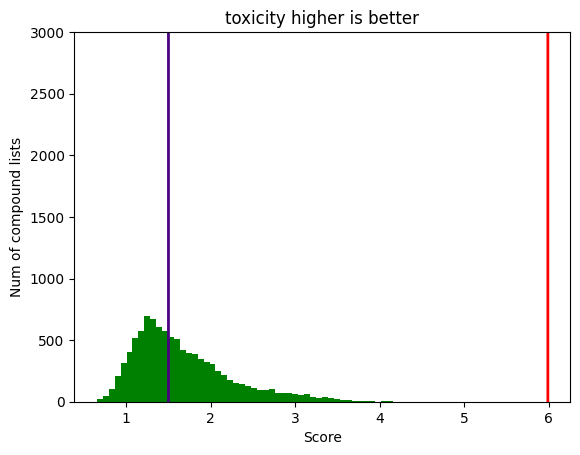

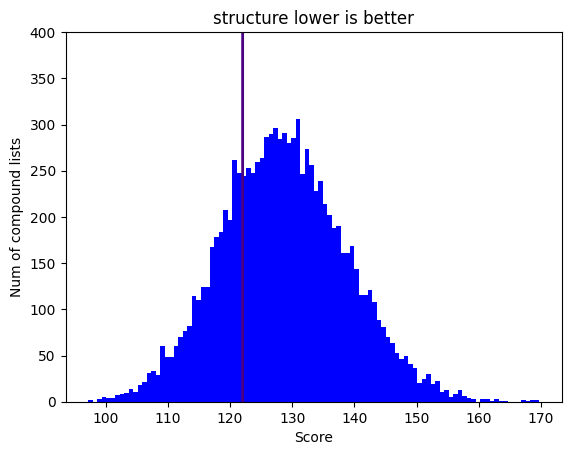

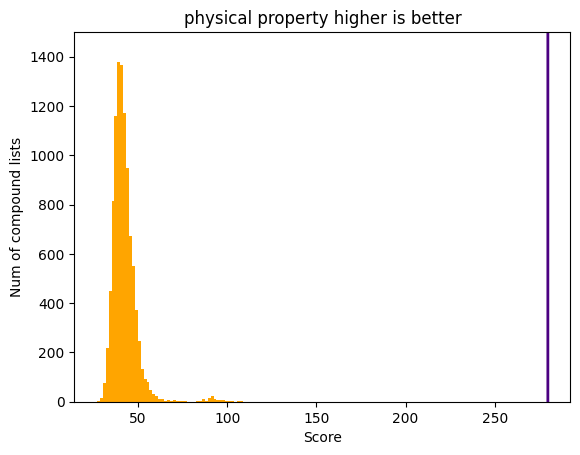

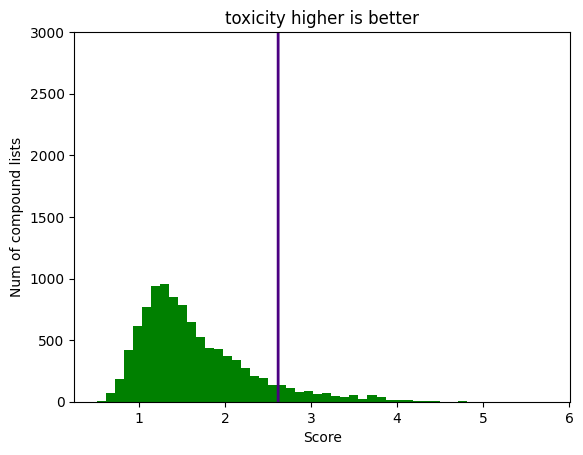

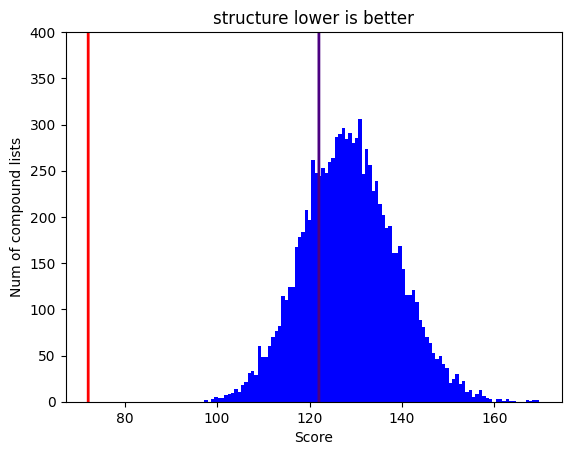

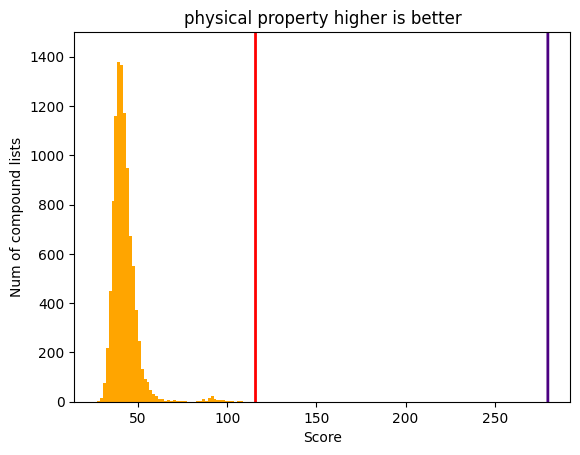

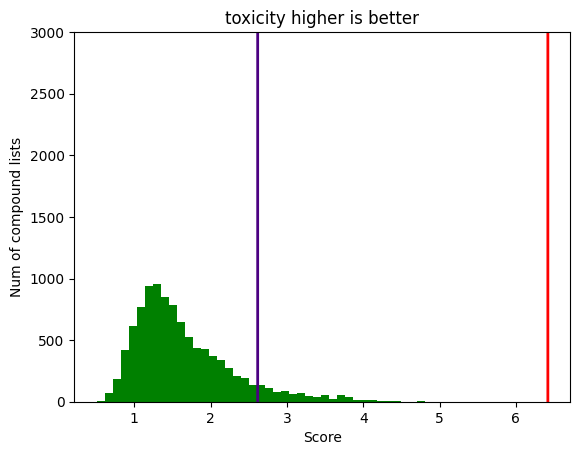

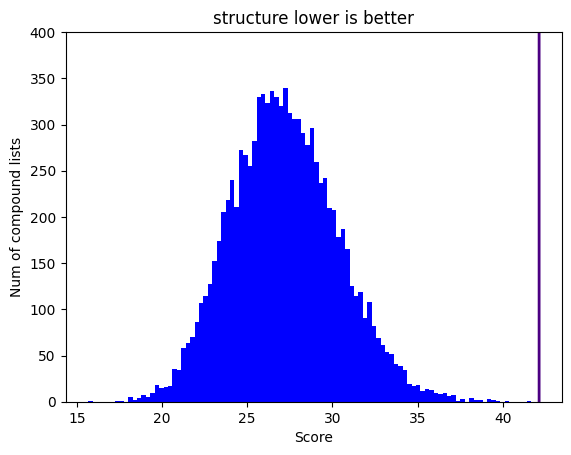

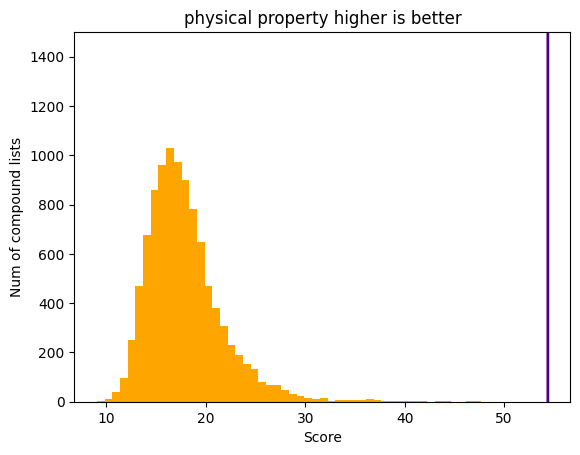

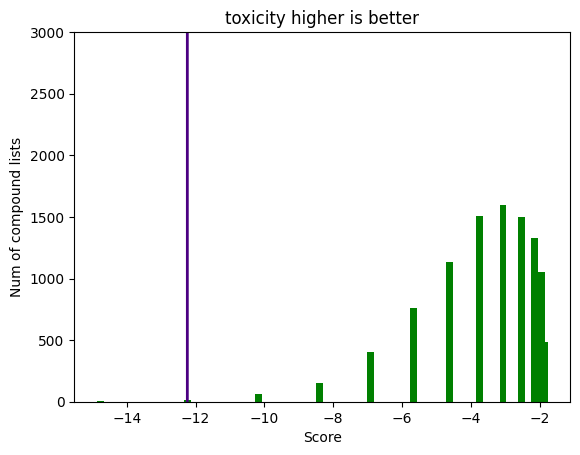

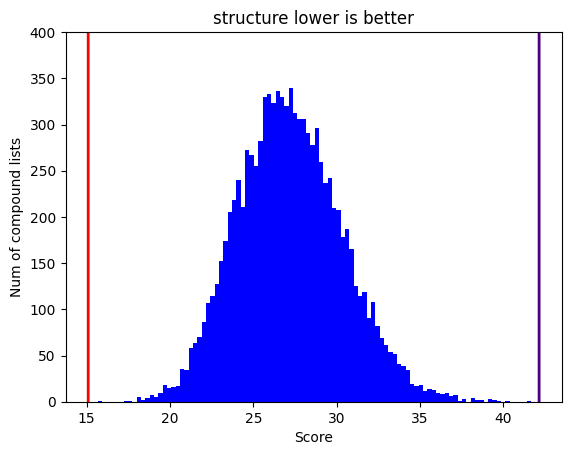

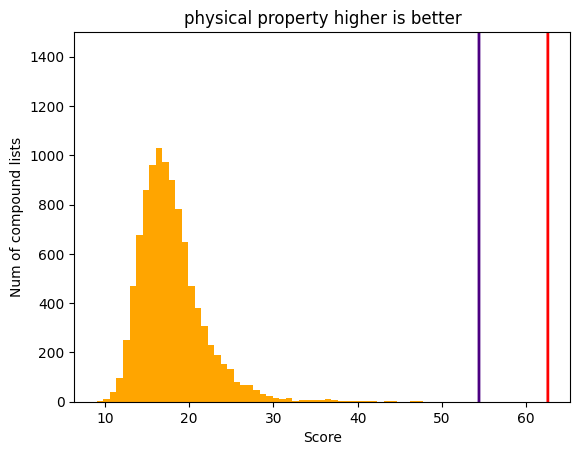

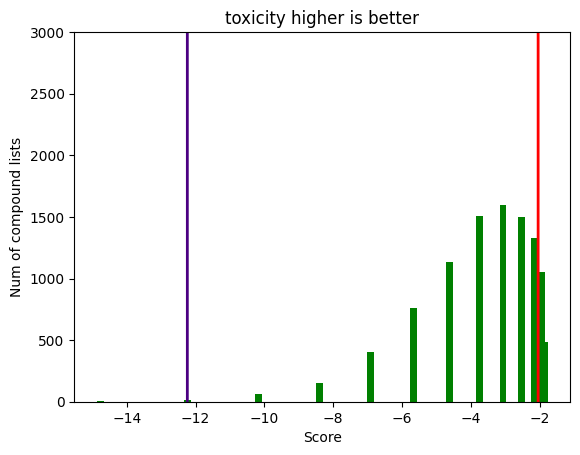

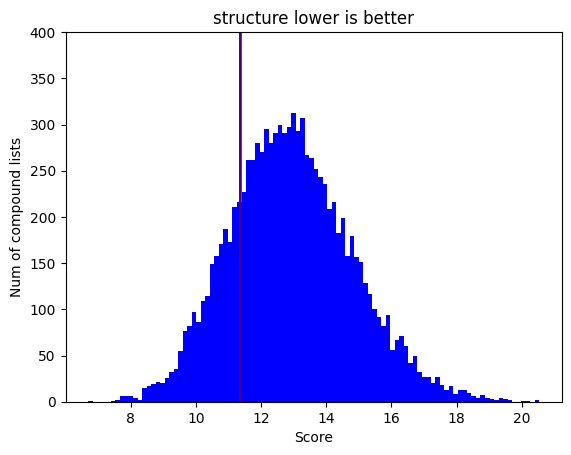

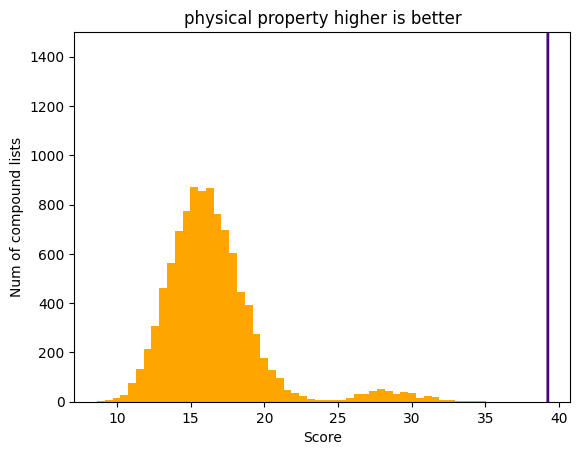

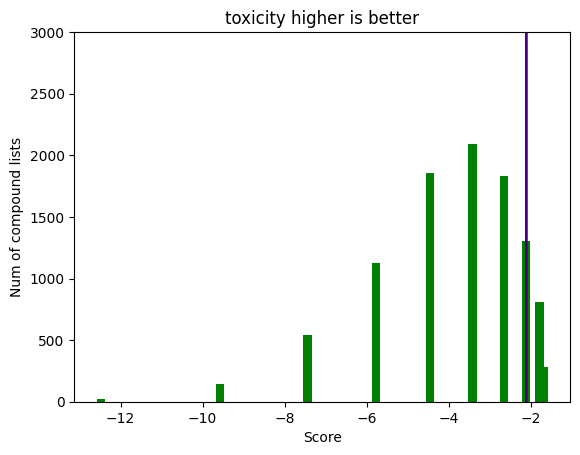

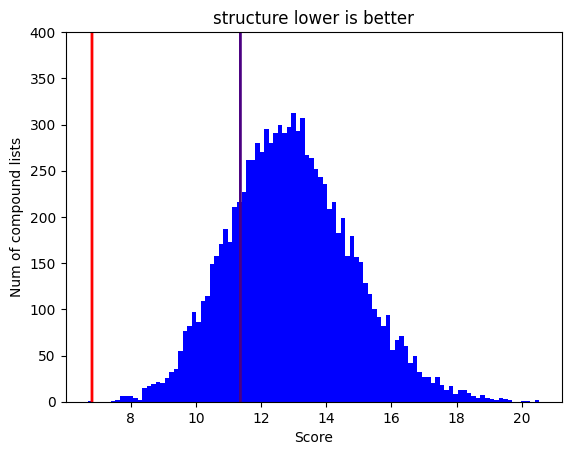

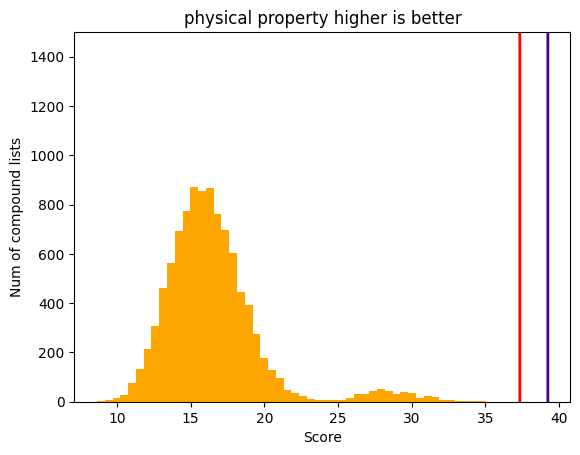

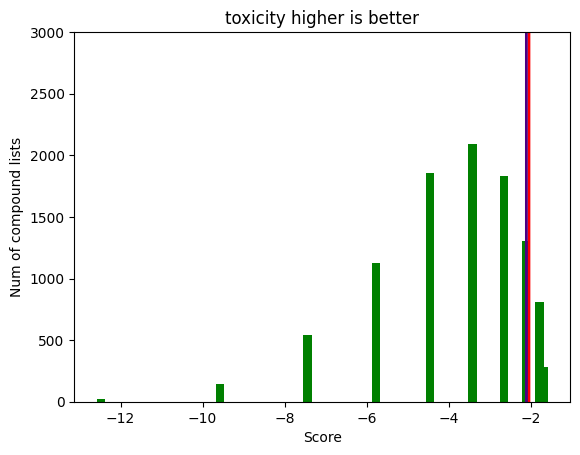

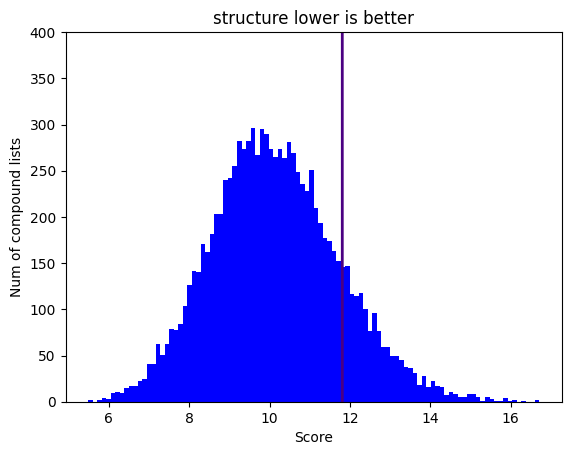

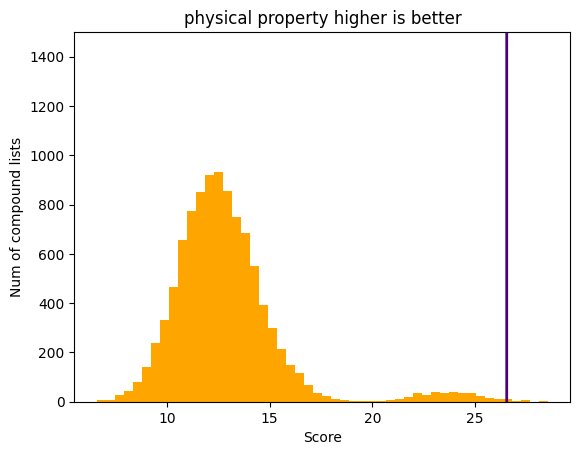

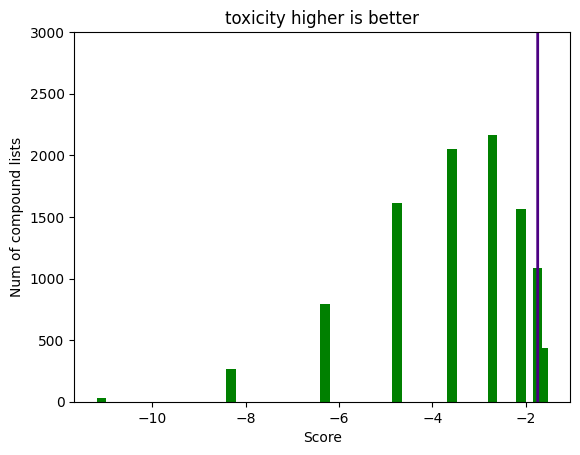

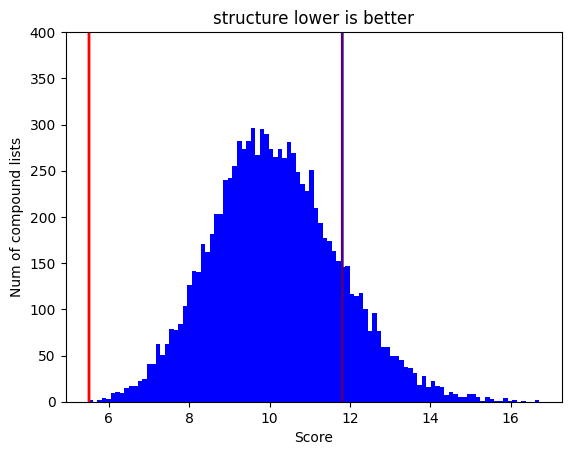

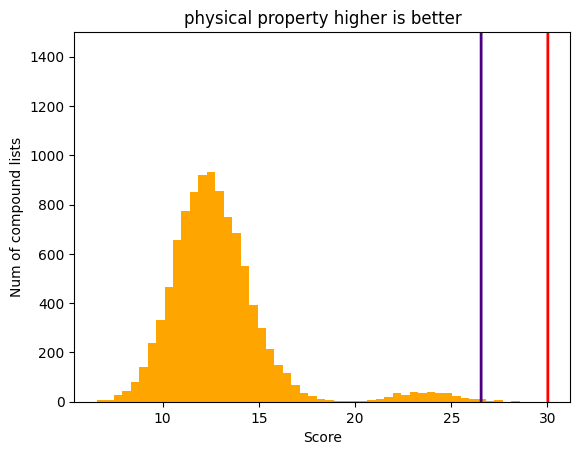

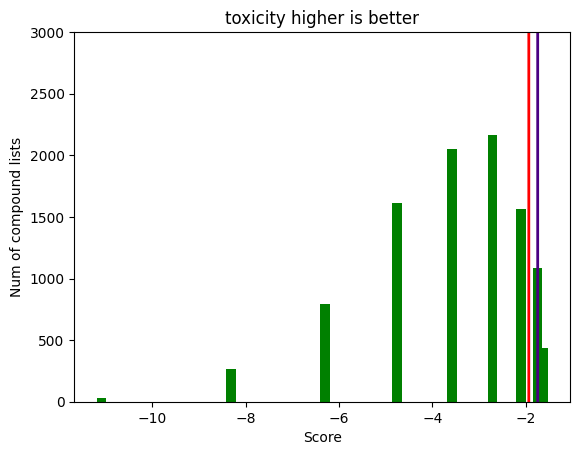

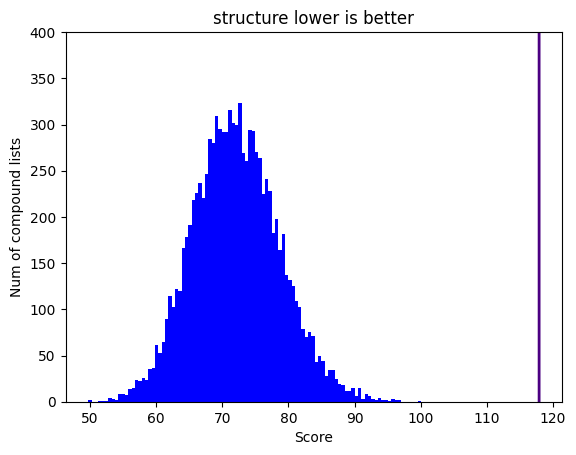

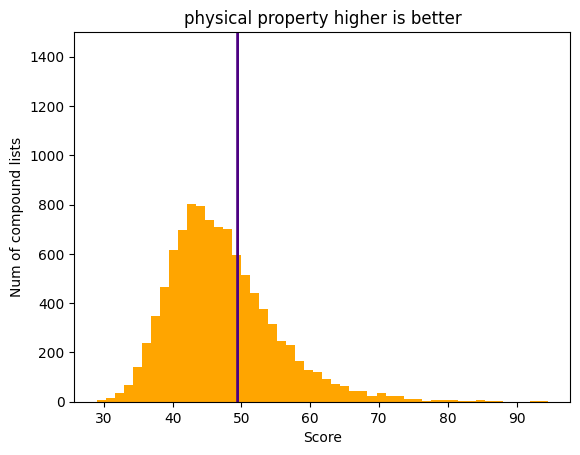

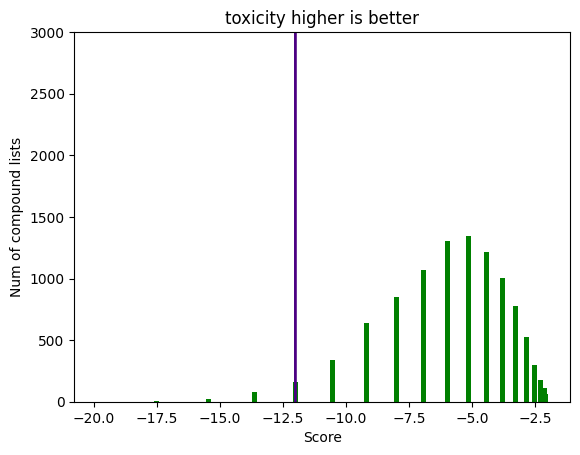

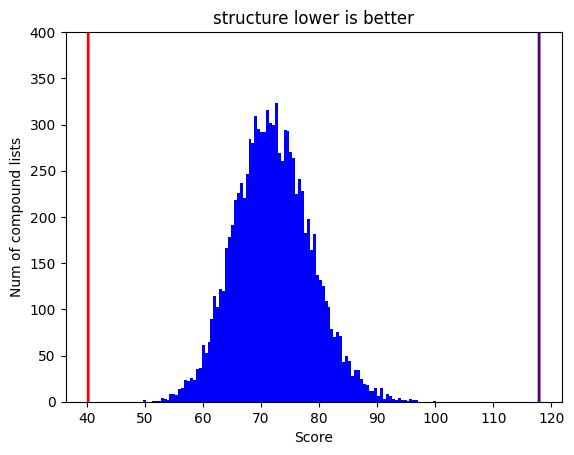

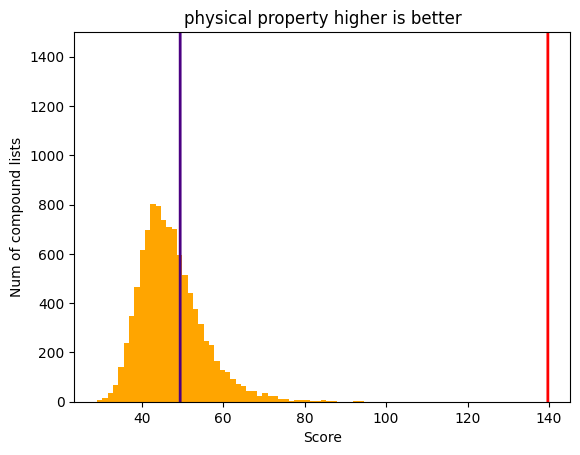

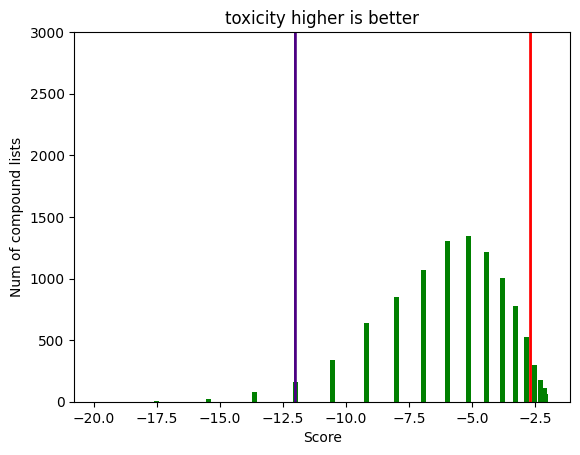

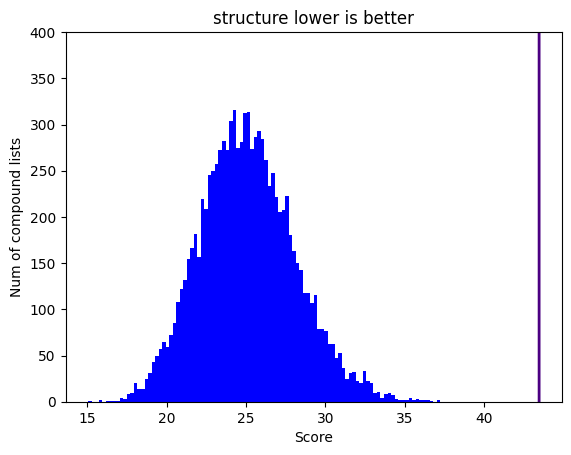

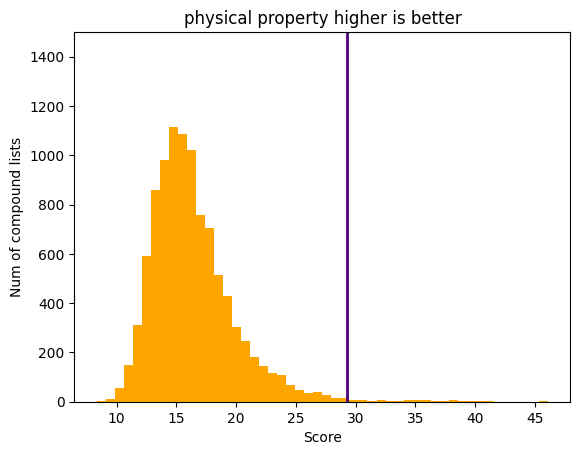

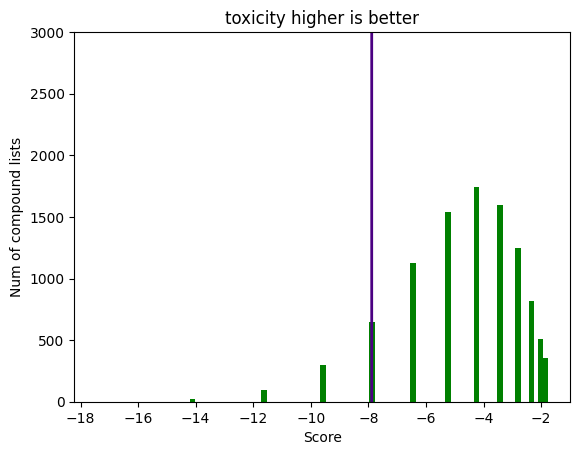

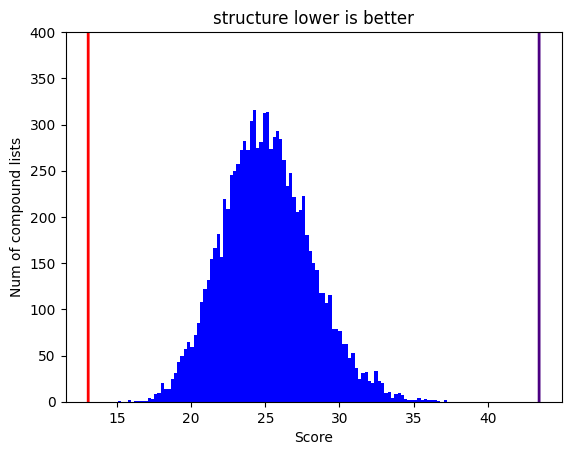

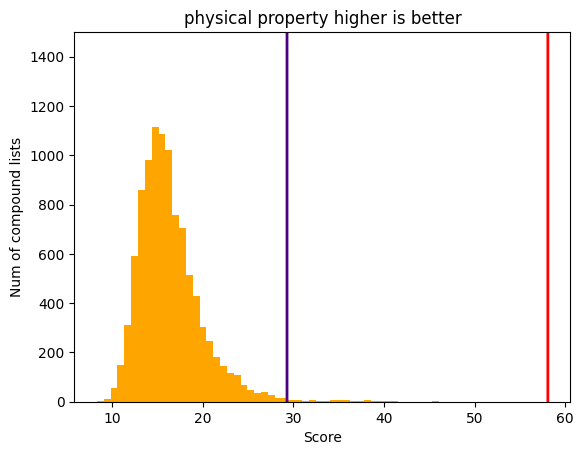

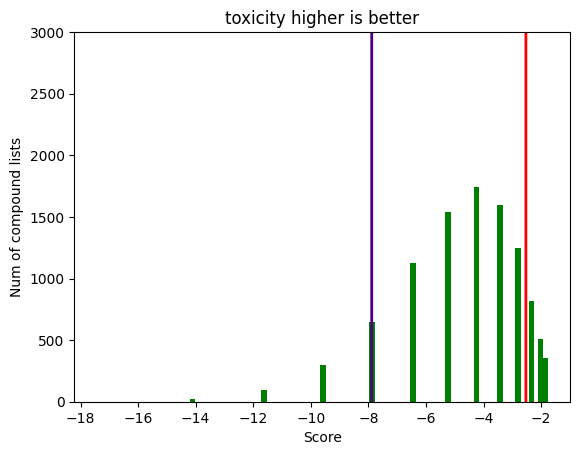

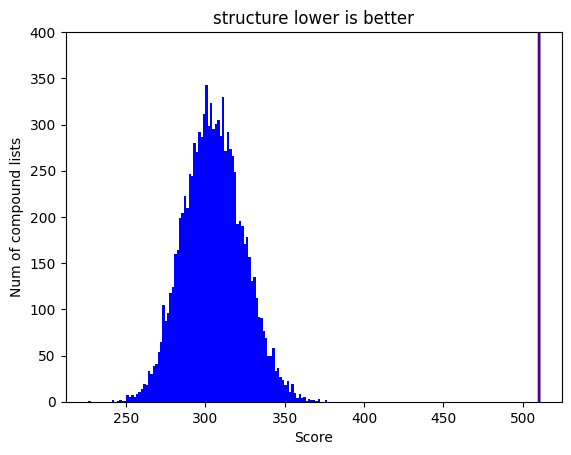

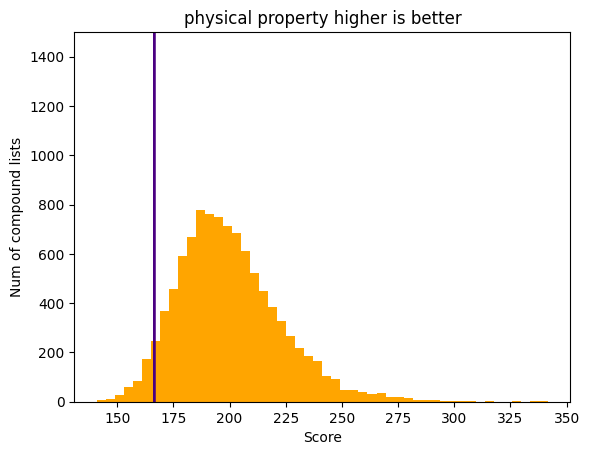

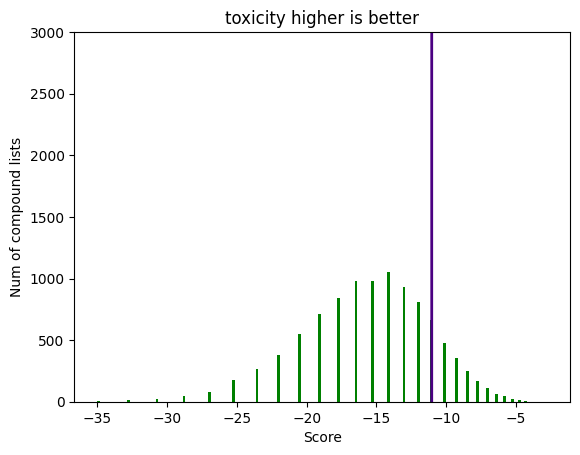

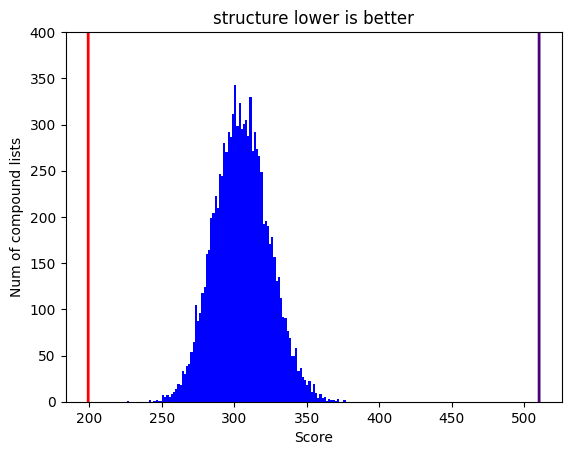

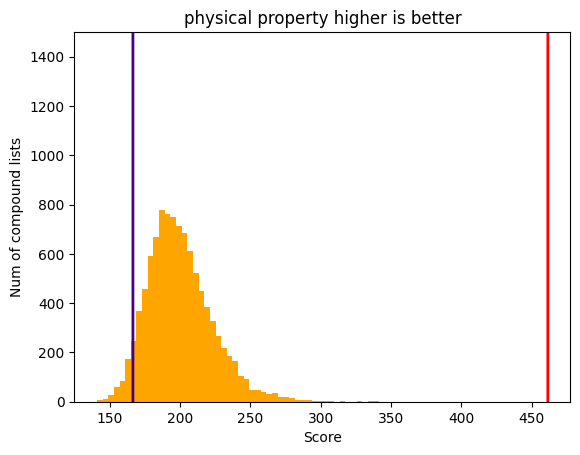

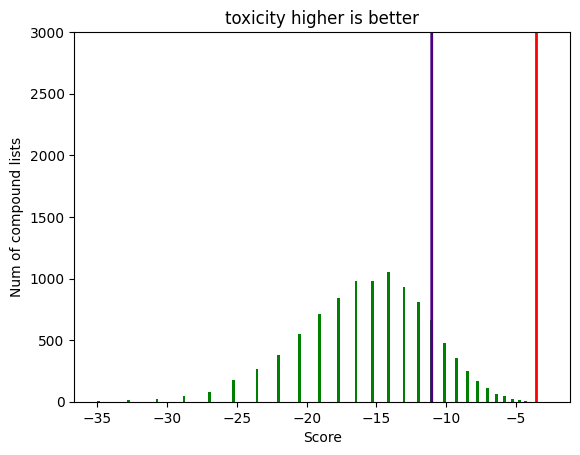

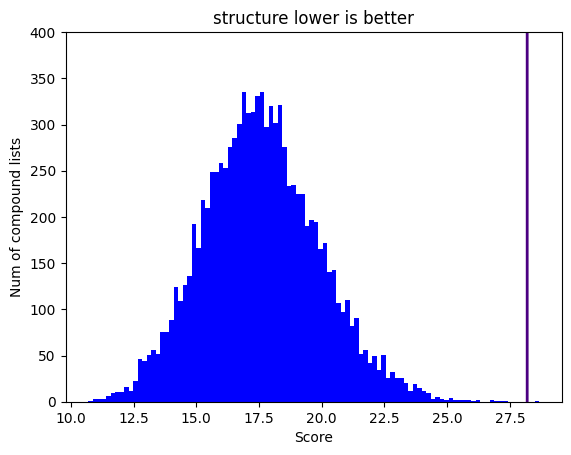

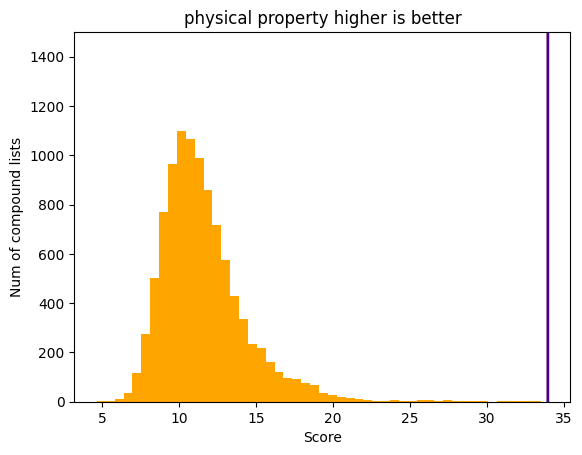

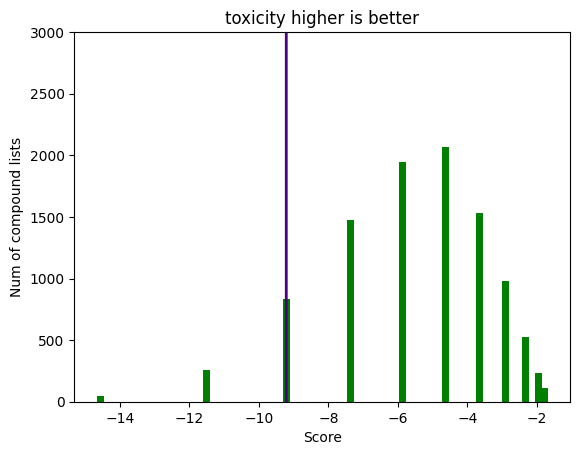

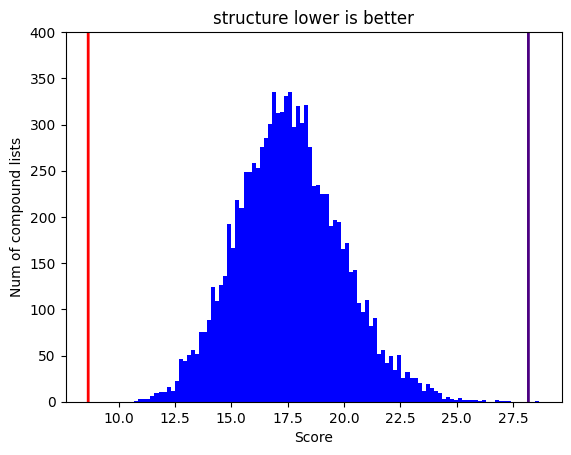

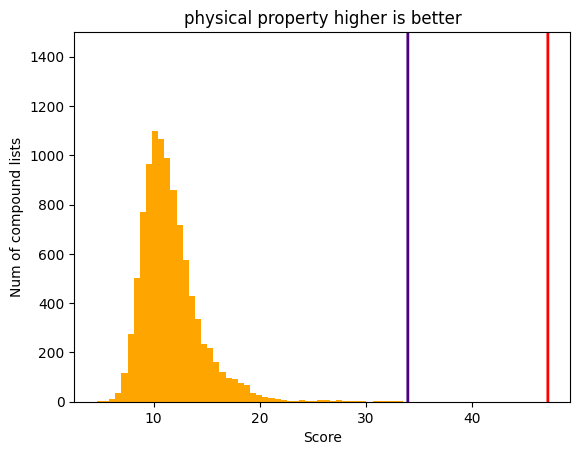

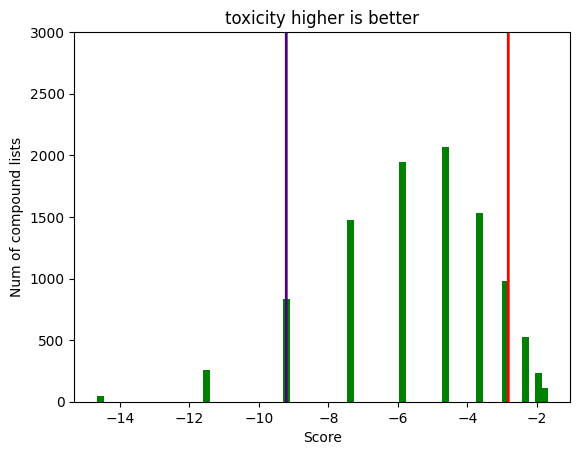

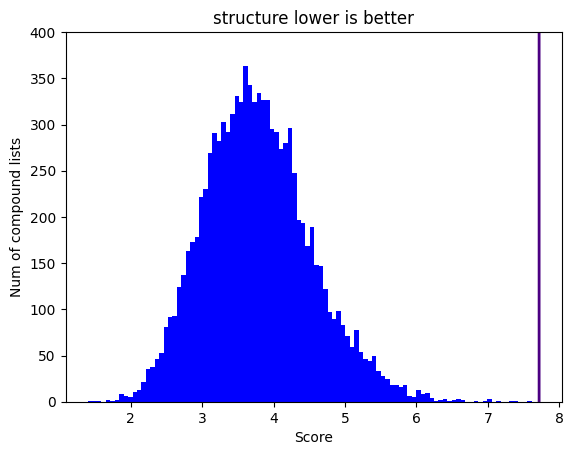

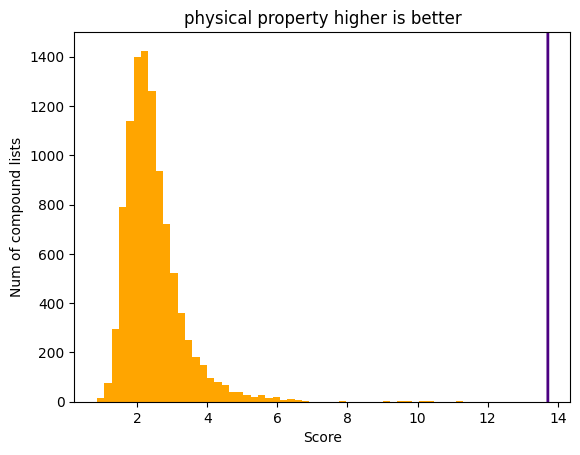

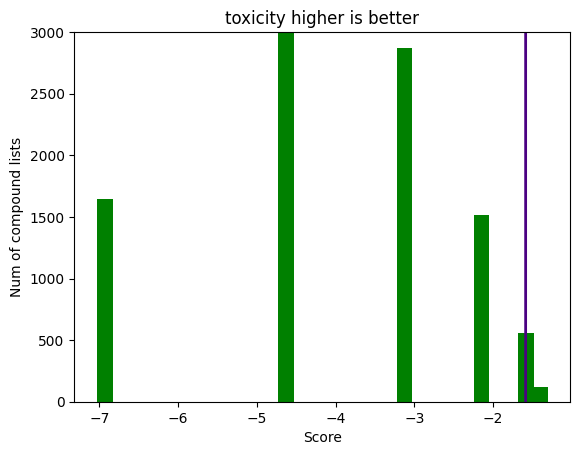

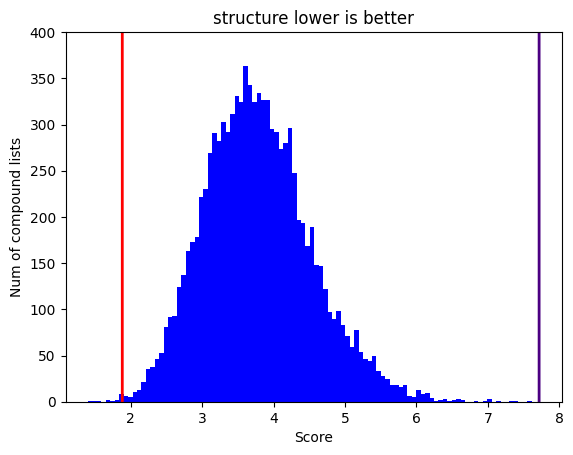

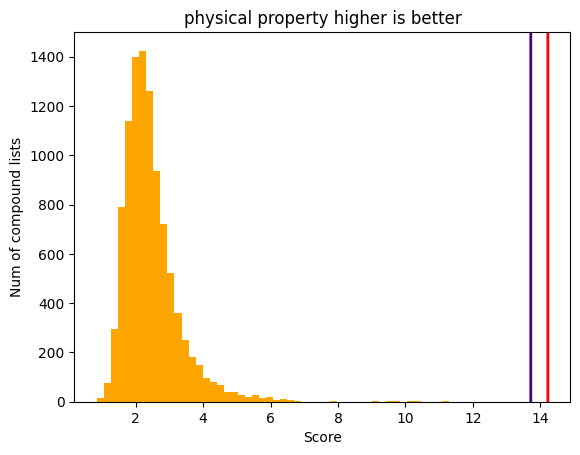

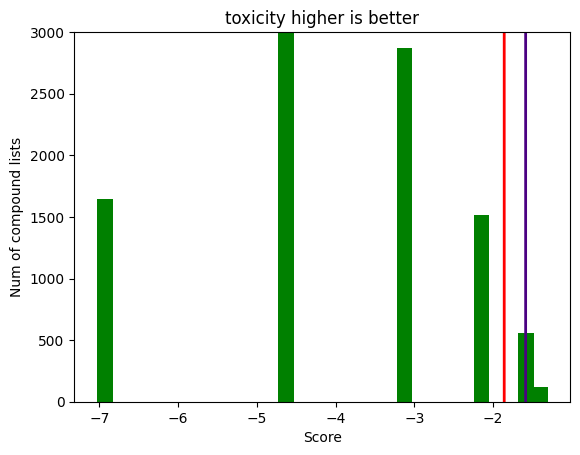

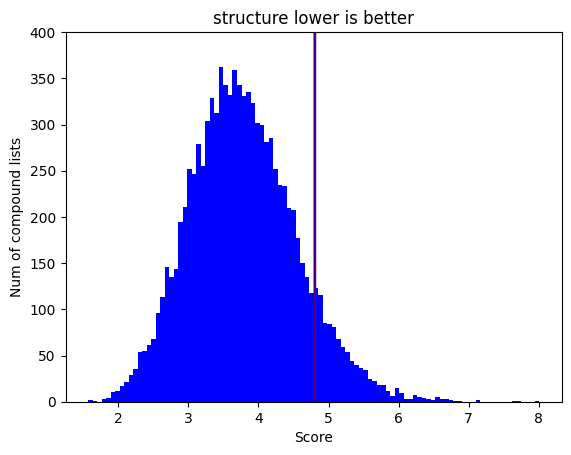

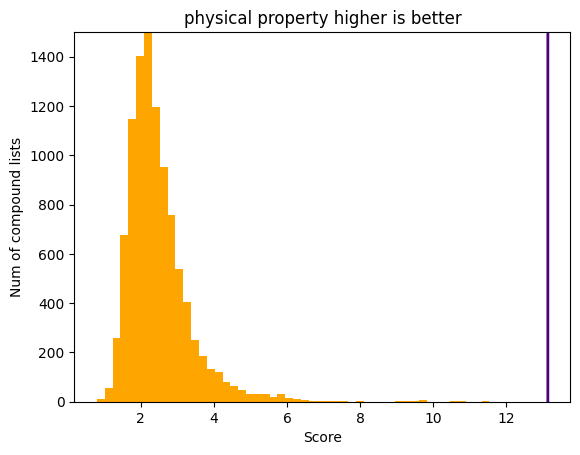

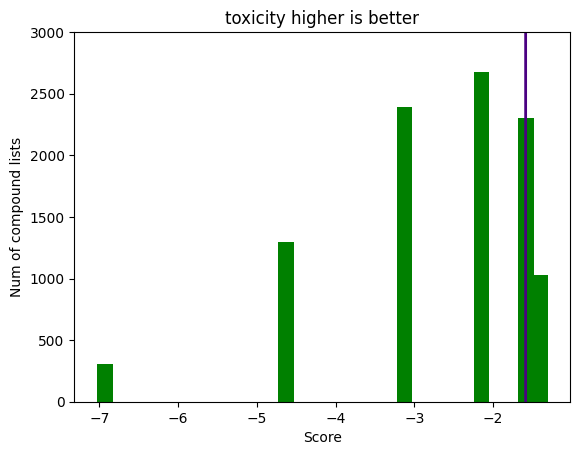

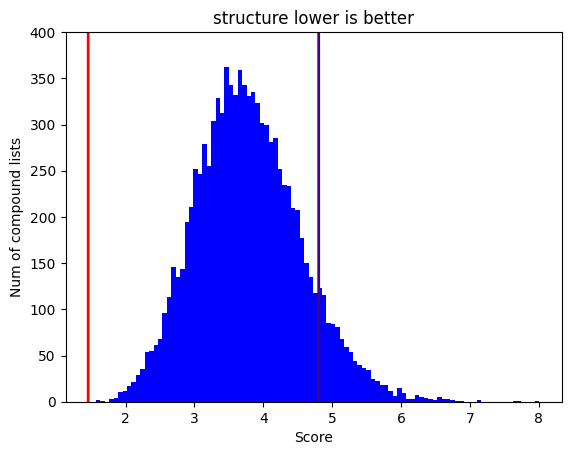

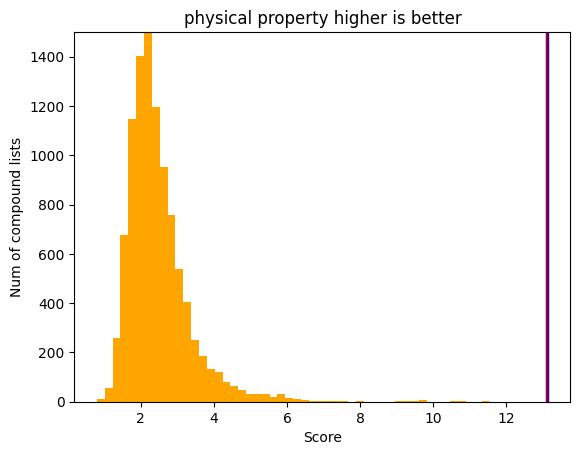

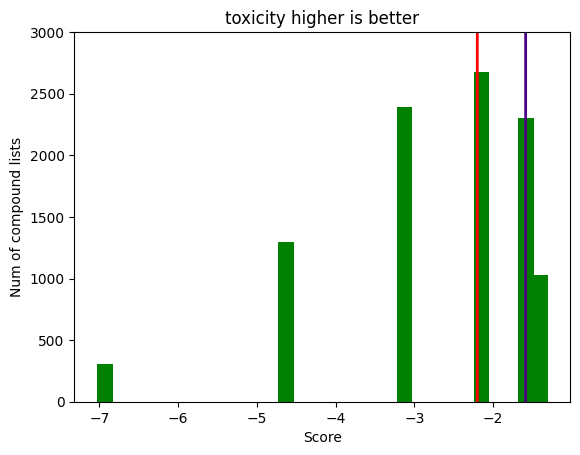

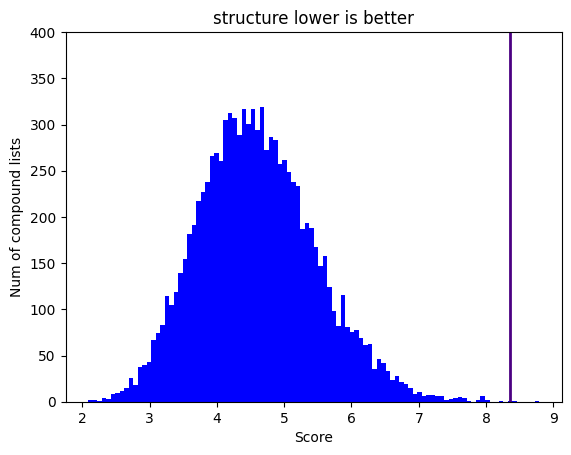

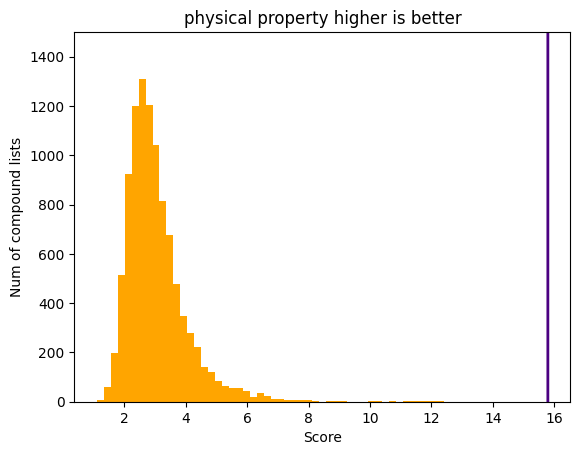

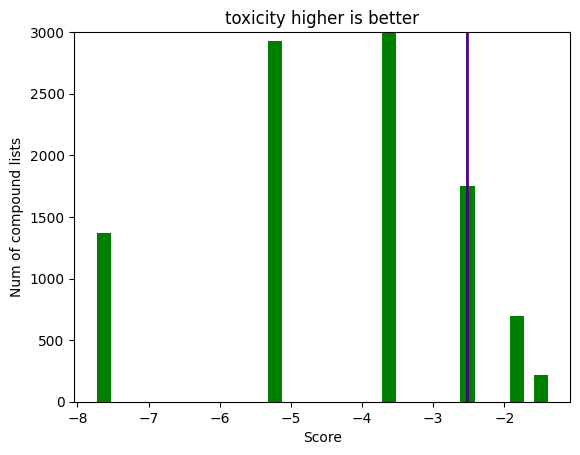

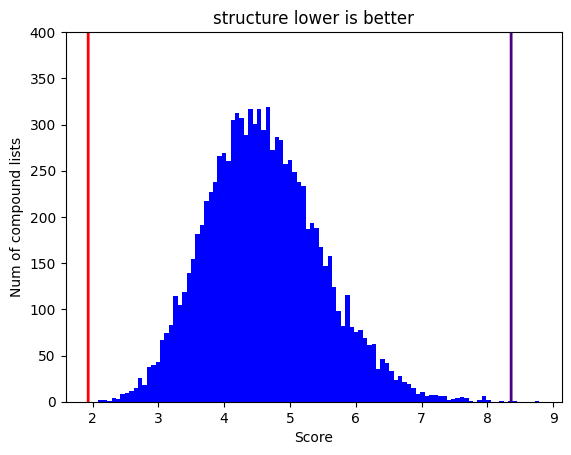

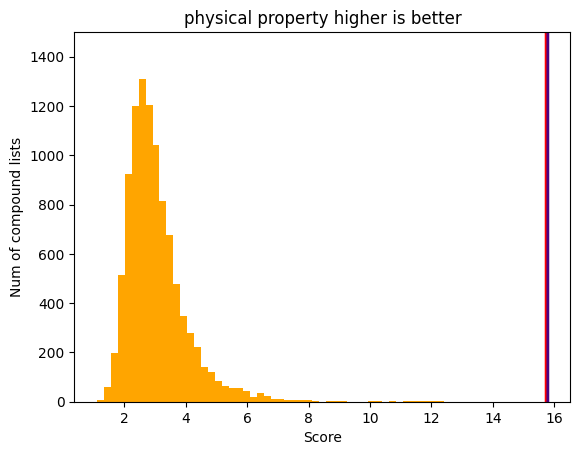

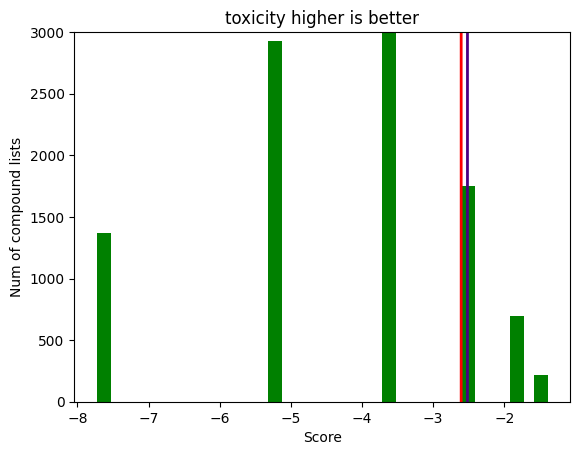

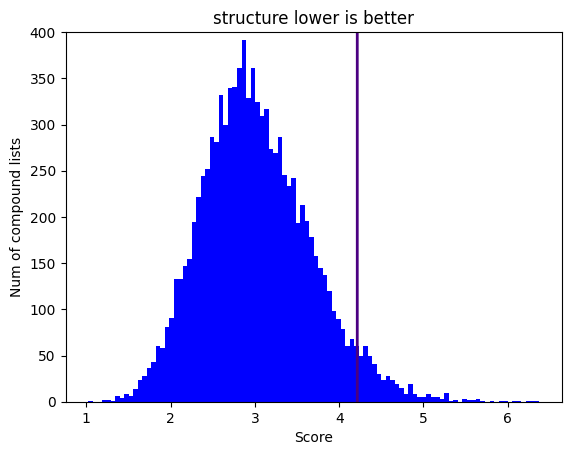

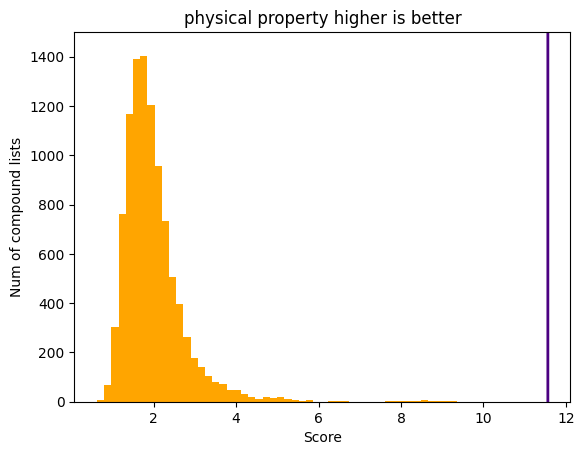

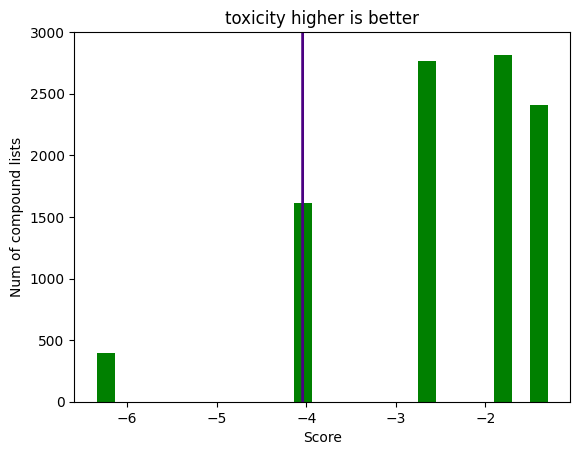

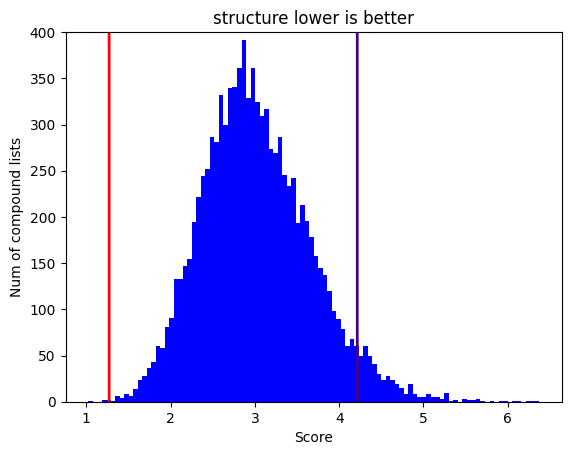

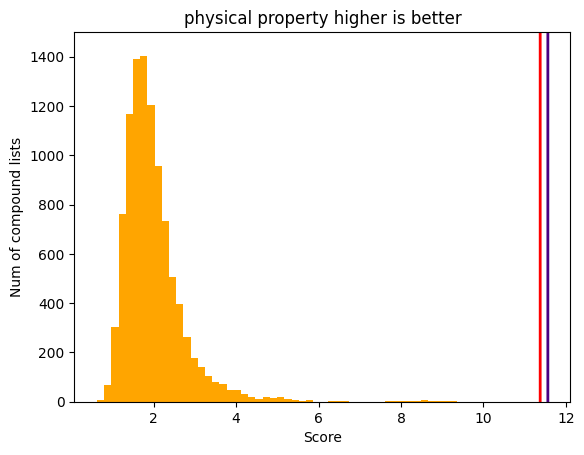

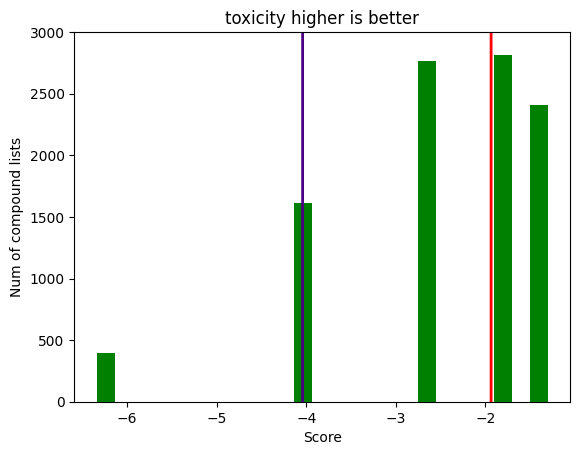

In [11]:
import collections
for test_num in tqdm(["0701", "0702", "0907", "1001", "1002", "0901", "0902", "0904", "0905"]):
    for lig in ["ago", "anta"]:

        if test_num in ["0701", "0702", "0907", "1001", "1002"]:
            if lig == "ago":
                lig = "!"
            else:
                continue

        date = 241219
        num = 1
        
        trys = str(date) + "_" + str(num)
        if lig in ["ago", "anta"]:
            test_name = test_num + "_" + lig
        else:
            test_name = test_num
        
        lookup = pickle_load(f"../../data/processed/{test_name}/for_GA_lookup.pickle")
        cas_tox = pd.read_csv(f"../../data/processed/{test_name}/cas_sev_use.tsv", sep="\t", header=None)
        val = pd.read_csv(f"../../data/processed/{test_name}/validation_pubchem.tsv", sep="\t", header=None) 
        val_lookup = pickle_load(f"../../data/processed/{test_name}/validation_lookup.pickle")
        scores = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/score.tsv", sep="\t", header=None)
        
        all_cass = []
        all_toxs = []
        for i in range(len(cas_tox)):
            all_cass.append(cas_tox.iloc[i,0])
            all_toxs.append(cas_tox.iloc[i,1])

        if len(set(all_toxs)) == 2:
            tox_scoring = "descrete"
        else:
            tox_scoring = "continuous"

        if tox_scoring == "continuous":
            standardized_toxs = robust_z(all_toxs)
        elif tox_scoring == "descrete":
            standardized_toxs = all_toxs

        def multi_objective_optimization(individual):
            structure_score = 0
            phisical_score = 0
            penalty = [100000, -100000, -100000]

            if len(individual) != IND_INIT_SIZE:
                return penalty[0], penalty[1], penalty[2]
            
            toxs = []
            for i in range(len(list(individual))):
                num = list(individual)[i]
                toxs.append(standardized_toxs[num])

            if tox_scoring == "descrete":
                count_t = 0
                for i in range(len(toxs)):
                    if toxs[i] == 1:
                        count_t += 1
                N = len(toxs)
                p = 0.5
                likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
                toxicity_score = math.log(likelihood)

            elif tox_scoring == "continuous":
                toxicity_score = np.std(toxs)

            t = list(itertools.combinations(individual,2))
            for i in range(len(t)):
                if t[i][0] == t[i][1]:
                    print("!", flush=True)
                    return penalty[0], penalty[1], penalty[2]

            for i in range(len(t)):
                try:
                    dict_t = lookup[f"{all_cass[t[i][0]]}, {all_cass[t[i][1]]}"]
                except:
                    dict_t = lookup[f"{all_cass[t[i][1]]}, {all_cass[t[i][0]]}"]
                structure = dict_t[0]
                phisical = dict_t[1]
                structure_score += structure
                phisical_score += phisical

            return structure_score, phisical_score, toxicity_score

        val_cas = []
        val_toxs = []
        for i in range(len(val)):
            val_cas.append(val.iloc[i,0])
            val_toxs.append(val.iloc[i,1])

        if len(set(val_toxs)) == 2:
            tox_scoring = "descrete"
        else:
            tox_scoring = "continuous"

        if tox_scoring == "continuous":
            standardized_toxs_val = robust_z(val_toxs)
        elif tox_scoring == "descrete":
            standardized_toxs_val = val_toxs

        def multi_objective_optimization_val(individual):
            structure_score = 0
            phisical_score = 0
            penalty = [100000, -100000, -100000]
            
            toxs = []
            for i in range(len(list(individual))):
                num = list(individual)[i]
                toxs.append(standardized_toxs_val[num])

            if tox_scoring == "descrete":
                count_t = 0
                for i in range(len(toxs)):
                    if toxs[i] == 1:
                        count_t += 1
                N = len(toxs)
                p = 0.5
                likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
                toxicity_score = math.log(likelihood)

            elif tox_scoring == "continuous":
                toxicity_score = np.std(toxs)

            t = list(itertools.combinations(individual,2))
            for i in range(len(t)):
                if t[i][0] == t[i][1]:
                    print("!", flush=True)
                    return penalty[0], penalty[1], penalty[2]

            for i in range(len(t)):
                try:
                    dict_t = val_lookup[f"{val_cas[t[i][0]]}, {val_cas[t[i][1]]}"]
                except:
                    dict_t = val_lookup[f"{val_cas[t[i][1]]}, {val_cas[t[i][0]]}"]
                structure = dict_t[0]
                phisical = dict_t[1]
                structure_score += structure
                phisical_score += phisical

            return structure_score, phisical_score, toxicity_score

        val_num = [i for i in range(len(val))]
        val_score = multi_objective_optimization_val(val_num)

        tox_r_fp = []
        bussei_r_fp = []
        tani_r_fp = [] 

        count = 0
        IND_INIT_SIZE = len(val)

        while count < 10000:
            a = [random.randint(0, len(cas_tox)-1) for i in range(IND_INIT_SIZE)] 
            a = set(a)
            while len(a) != IND_INIT_SIZE:
                a.add(random.randint(0, len(cas_tox)-1))
            score_moo = multi_objective_optimization(a)
            tox_r_fp.append(score_moo[2])
            bussei_r_fp.append(score_moo[1])
            tani_r_fp.append(score_moo[0])
            count += 1
        
        os.makedirs(f"../../data/result/{test_name}/GA_{trys}/fig1", exist_ok=True)
        os.makedirs(f"../../data/result/{test_name}/GA_{trys}/fig4", exist_ok=True)

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        y = np.arange(0, 600, 0.5)
        x_1 = []
        for i in range(len(y)):
            x_1.append(val_score[0])

        ax.hist(tani_r_fp, bins=100, color="blue")
        ax.set_title('structure lower is better')
        ax.set_xlabel('Score')
        ax.set_ylabel('Num of compound lists')
        ax.set_ylim(0,400)
        ax.plot(x_1, y, '-', linewidth=2, color="indigo")
        fig.show()
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig1/structure_comp_random_only_val.png")

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        y = np.arange(0, 1500, 0.5)
        x_1 = []
        for i in range(len(y)):
            x_1.append(val_score[1])

        ax.set_title('physical property higher is better')
        ax.set_xlabel('Score')
        ax.set_ylabel('Num of compound lists')
        ax.set_ylim(0, 1500)
        ax.plot(x_1, y, '-', linewidth=2, color="indigo")
        fig.show()
        plt.hist(bussei_r_fp, bins=50, color="orange")
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig1/physical_property_comp_random_only_val.png")

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        y = np.arange(0, 3000, 0.5)
        x = []
        for i in range(len(y)):
            x.append(scores.iloc[-1,4])
        x_1 = []
        for i in range(len(y)):
            x_1.append(val_score[2])

        if tox_scoring == "descrete":
            c = collections.Counter(tox_r_fp)
            ax.set_title('toxicity higher is better')
            ax.set_xlabel('Score')
            ax.set_ylabel('Num of compound lists')
            ax.set_ylim(0, 3000)
            ax.plot(x_1, y, '-', linewidth=2, color="indigo")
            plt.bar(list(c.keys()), list(c.values()), width=0.2, color="green")
            fig.show()
        elif tox_scoring == "continuous":
            plt.hist(tox_r_fp, bins=50, color="green")
            ax.set_title('toxicity higher is better')
            ax.set_xlabel('Score')
            ax.set_ylabel('Num of compound lists')
            ax.set_ylim(0, 3000)
            ax.plot(x_1, y, '-', linewidth=2, color="indigo")
            fig.show()
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig1/toxicity_comp_random_only_val.png")

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        y = np.arange(0, 600, 0.5)
        x = []
        for i in range(len(y)):
            x.append(scores.iloc[-1,0])
        x_1 = []
        for i in range(len(y)):
            x_1.append(val_score[0])

        ax.hist(tani_r_fp, bins=100, color="blue")
        ax.set_title('structure lower is better')
        ax.set_xlabel('Score')
        ax.set_ylabel('Num of compound lists')
        ax.set_ylim(0,400)
        ax.plot(x, y, '-', linewidth=2, color="red")
        ax.plot(x_1, y, '-', linewidth=2, color="indigo")
        fig.show()
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig4/structure_comp_random.png")

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        y = np.arange(0, 1500, 0.5)
        x = []
        for i in range(len(y)):
            x.append(scores.iloc[-1,2])
        x_1 = []
        for i in range(len(y)):
            x_1.append(val_score[1])

        ax.set_title('physical property higher is better')
        ax.set_xlabel('Score')
        ax.set_ylabel('Num of compound lists')
        ax.set_ylim(0, 1500)
        ax.plot(x, y, '-', linewidth=2, color="red")
        ax.plot(x_1, y, '-', linewidth=2, color="indigo")
        fig.show()
        plt.hist(bussei_r_fp, bins=50, color="orange")
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig4/physical_property_comp_random.png")

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        y = np.arange(0, 3000, 0.5)
        x = []
        for i in range(len(y)):
            x.append(scores.iloc[-1,4])
        x_1 = []
        for i in range(len(y)):
            x_1.append(val_score[2])

        if tox_scoring == "descrete":
            c = collections.Counter(tox_r_fp)
            ax.set_title('toxicity higher is better')
            ax.set_xlabel('Score')
            ax.set_ylabel('Num of compound lists')
            ax.set_ylim(0, 3000)
            ax.plot(x, y, '-', linewidth=2, color="red")
            ax.plot(x_1, y, '-', linewidth=2, color="indigo")
            plt.bar(list(c.keys()), list(c.values()), width=0.2, color="green")
            fig.show()
        elif tox_scoring == "continuous":
            plt.hist(tox_r_fp, bins=50, color="green")
            ax.set_title('toxicity higher is better')
            ax.set_xlabel('Score')
            ax.set_ylabel('Num of compound lists')
            ax.set_ylim(0, 3000)
            ax.plot(x, y, '-', linewidth=2, color="red")
            ax.plot(x_1, y, '-', linewidth=2, color="indigo")
            fig.show()
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig4/toxicity_comp_random.png")